# **Inspect the properties on Wikidata**

In this notebook, we will inspect the different properties of Wikidata and show which ones are interesting to study in statistical analysis. We choose to carry out the examination of the properties on Wikidata due to the number of persons much more important than DBpedia and BnF Data (135819 persons - these are the results of May 25, 2021). 

The most essential thing to focus on is which properties are present in the maximum number of instances. It is also important that the instances share most of the properties.

To do this, we set up a query that retrieves all the properties but first, we exclude the properties including an identifier (because there is no interest to study and this reduces the number of responses). We also exclude properties with too few instances (relative to the number of instances in the query). It drastically decreases the execution time of the request.

All the queries are first written on the SQLite database to keep them in memory. (to create it: see. https://github.com/Semantic-Data-for-Humanities/Economists_Jurists/blob/development/Notebooks/Merge/Database_SQlite.ipynb).

In a second time, a more detailed analysis of the properties and the connection between them is realized.


### libraries

In [1]:
    
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pprint
import csv
# from bs4 import BeautifulSoup

from collections import Counter
from operator import itemgetter
import pandas as pd

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import scipy.stats
import pandas as pd
import pprint
import csv
import ast
import re
from collections import Counter
from operator import itemgetter

import networkx as nx
import os

In [9]:
import sparql_functions as spqf

# Execution of the query

In [10]:
### It's define the database ligne to use
pk_query = 40

# Connexion to the database
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

c = conn.cursor()

### It runs the query on the SQLite database to get the row values 
c.execute('SELECT * FROM query WHERE pk_query = ?', [pk_query]) ### a list around argument is needed for a string longer then one

rc = c.fetchone()

# close connexion
conn.close()


In [11]:
print("\033[1mDescription:\033[0m\n\n"+rc[3]  + "\n-----\n" +"\033[1mDatabase:\033[0m\n\n"+ rc[2]+  "\n----\n"+"\033[1mNotes:\033[0m\n\n" +rc[7] + "\n----\n"+"\033[1mTime stamp:\033[0m\n\n"+rc[8]+  "\n--------------\n" +"\033[1mSparl endpoint:\033[0m\n\n"+   rc[5] + "\n-----------\n" +"\033[1mQuery:\033[0m\n\n"+ rc[6])

Description:

SELECT: This query gets all the properties of attorney.
I only exclude all properties with IDs.
-----
Database:

Wikidata
----
Notes:


----
Time stamp:

2021-05-26 15:41:12
--------------
Sparl endpoint:

https://query.wikidata.org/sparql
-----------
Query:

SELECT  ?prop ?propLabel ?direction ?eff ?propDescription
WHERE{ { 
        SELECT  ?prop ?propLabel ?propDescription ?direction ?eff
WHERE{
    {
  SELECT   ?prop ?direction  (COUNT(*) as ?eff) # ?pLabel
 WHERE
  { 
  hint:Query hint:optimizer "None" .
      { ?person  wdt:P106 wd:Q758225. # attorney at law | result: 100 person
       ?person ?p ?o.
       ?prop wikibase:directClaim ?p .
       BIND("out" AS ?direction)
      }
  UNION
       {
       ?person  wdt:P106  wd:Q758225.
       ?s ?p ?person.
       ?prop wikibase:directClaim ?p .
       BIND("in" AS ?direction)
      }
  }

GROUP BY ?prop ?direction # ?pLabel
               }
SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
    }
FILTER

In [98]:
### Execute the SPARQL query wrapped in the function in the library _sparql_functions.py_
# The first setting correspond to SPARQL Endpoint, the seconde to the query
q = spqf.get_json_sparql_result(rc[5],rc[6])

<class 'dict'>


In [99]:
### This fonction retrieves and shapes time

# definition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# execution
timestamp_formatted_for_file_name()

'20210703_100751'

In [100]:
# Define the file addresses, the existing one and new one
original_db = 'data/sparql_queries.db'

timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [101]:
## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(original_db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210703_100753.sqlite'

In [102]:
### store the answer of the SPARQL endpoint in the 'result'

conn = sql.connect(original_db)
c = conn.cursor()
values = (pk_query, str(q), rc[3], timestamp_formatted_for_file_name())

# https://www.techonthenet.com/sqlite/functions/now.php
c.execute("INSERT INTO result (fk_query, result, description, timestmp) VALUES (?,?,?,?)", values)
# commit the insertion and close the database
# !! REQUIRE to be enabled to commit to the SQLite database !!
conn.commit()
conn.close()

# Inspect the queries

In [16]:
### Inspect the resultat after an insert

# Choose the row of the database to get
pk_result = ('1')

# connexion to the database
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

### execute the query on the SQLite database to retrieve the values of the row
c = conn.cursor()
c.execute('SELECT * FROM result WHERE pk_result = ?', (pk_result,))
result_q = c.fetchone()

# close connexion
conn.close()
# result_q[3]

In [17]:
### Transform string to dict
## Doc.:
# https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
import ast
d = ast.literal_eval(result_q[3])
type(d)

dict

In [20]:
##### Transform the result into a list with a fonction of the library #####

#### Result of the query
r_query = [l for l in spqf.sparql_result_to_list(d)]
print(len(r_query))
#r_query

25


## Economist

In this query, we exclude the properties with less of 5000 in number.
In total, There is 29322 instances

``
 [['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '73909',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '62166',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '35783',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '35078',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '31125',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '30317',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '28166',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '26894',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '20250',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '19451',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '18100',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '17333',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '16075',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '14657',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P184',
  'doctoral advisor',
  'in',
  '14250',
  'person who supervised the doctorate or PhD thesis of the subject'],
 ['http://www.wikidata.org/entity/P185',
  'doctoral student',
  'out',
  '14016',
  'doctoral student(s) of a professor'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '11349',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '10821',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '8892',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '6947',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '6532',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '6217',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '5498',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '5071',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '5038',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")']]
 ``

## Jurist

In this query, we exclude the properties with less of 5000 in number.
In total, There is 24886 instances

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '66370',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '32159',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '31979',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '30705',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '30196',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '23810',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '22410',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '22330',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '17743',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '15211',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '13590',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '13225',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '12841',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '12196',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '11911',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '9301',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '9187',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '7102',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '7028',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '5288',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '5034',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).']]
``

## Lawyers

In this query, we exclude the properties with less of 5000 in number.
In total, There is 68033 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '164404',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '76557',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '75759',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '71898',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '70830',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '67515',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '65987',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '65664',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '54151',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '47430',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '41406',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '37867',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '33976',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '29448',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '28924',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '20170',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '18466',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '18032',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '17961',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '15770',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '14027',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '9979',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '7880',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '7494',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '7040',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '6769',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'in',
  '6351',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P119',
  'place of burial',
  'out',
  '6310',
  'location of grave, resting place, place of ash-scattering, etc. (e.g., town/city or cemetery) for a person or animal. There may be several places: e.g., re-burials, parts of body buried separately.']]
``

## Judge
In this query, we exclude the properties with less of 5000 in number.
In total, There is 68033 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '72138',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '36347',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '35776',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '34257',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '32572',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '30312',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '28203',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '26290',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '23809',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '21896',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '16535',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '14787',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '11530',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '9935',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '9263',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P1594',
  'judge',
  'in',
  '9088',
  'judge, magistrate or equivalent, presiding at a trial'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '8826',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '7878',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '6682',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '5684',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '5661',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '5649',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '5085',
  'person or organization for which the subject works or worked']]
``

## Attorney

In total, There is 100 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '283',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '129',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '125',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '124',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '124',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '114',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '111',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '93',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '65',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '61',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '50',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '46',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '45',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '41',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '33',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '31',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '28',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '22',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '18',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '17',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '15',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P551',
  'residence',
  'out',
  '14',
  'the place where the person is or has been, resident'],
 ['http://www.wikidata.org/entity/P1477',
  'birth name',
  'out',
  '12',
  'full name of a person at birth, if different from their current, generally used name (samples: John Peter Doe for Joe Doe, Ann Smith for Ann Miller)'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '12',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '11',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P119',
  'place of burial',
  'out',
  '11',
  'location of grave, resting place, place of ash-scattering, etc. (e.g., town/city or cemetery) for a person or animal. There may be several places: e.g., re-burials, parts of body buried separately.'],
 ['http://www.wikidata.org/entity/P509',
  'cause of death',
  'out',
  '11',
  "underlying or immediate cause of death.  Underlying cause (e.g. car accident, stomach cancer) preferred.  Use 'manner of death' (P1196) for broadest category, e.g. natural causes, accident, homicide, suicide"],
 ['http://www.wikidata.org/entity/P138',
  'named after',
  'in',
  '10',
  'entity or event that inspired the subject\'s name, or namesake (in at least one language). Qualifier "applies to name" (P5168) can be used to indicate which one'],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'out',
  '10',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '10',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P921',
  'main subject',
  'in',
  '9',
  'primary topic of a work (see also P180: depicts)'],
 ['http://www.wikidata.org/entity/P140',
  'religion',
  'out',
  '9',
  'religion of a person, organization or religious building, or associated with this subject'],
 ['http://www.wikidata.org/entity/P1196',
  'manner of death',
  'out',
  '9',
  "general circumstances of a person's death; e.g. natural causes, accident, suicide, homicide, etc.  Use 'cause of death' (P509) for the specific physiological mechanism, e.g. heart attack, trauma, pneumonia..."],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'in',
  '8',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions'],
 ['http://www.wikidata.org/entity/P856',
  'official website',
  'out',
  '8',
  'URL of the official homepage of an item (current or former) [if the homepage changes, add an additional statement with preferred rank. Do not remove the former URL]'],
 ['http://www.wikidata.org/entity/P5008',
  'on focus list of Wikimedia project',
  'out',
  '7',
  'property to indicate that an item is of particular interest for a Wikimedia project. This property does not add notability. Items should not be created with this property if they are not notable for Wikidata. See also P6104, P972, P2354.'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '7',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P1442',
  'image of grave',
  'out',
  '7',
  "picture of a person or animal's grave, gravestone or tomb"],
 ['http://www.wikidata.org/entity/P112',
  'founded by',
  'in',
  '6',
  'founder or co-founder of this organization, religion or place'],
 ['http://www.wikidata.org/entity/P1441',
  'present in work',
  'out',
  '6',
  'this (fictional or fictionalized) entity or person appears in that work as part of the narration (use P2860 for works citing other works, P361/P1433 for works being part of other works, P1343 for entities described in non-fictional accounts)'],
 ['http://www.wikidata.org/entity/P710',
  'participant',
  'in',
  '6',
  'person, group of people or organization (object) that actively takes/took part in an event or process (subject).  Preferably qualify with "object has role" (P3831). Use P1923 for participants that are teams.'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '6',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P101',
  'field of work',
  'out',
  '6',
  'specialization of a person or organization; see P106 for the occupation'],
 ['http://www.wikidata.org/entity/P1971',
  'number of children',
  'out',
  '6',
  'number of children of the person'],
 ['http://www.wikidata.org/entity/P25',
  'mother',
  'in',
  '5',
  'female parent of the subject. For stepmother, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P512',
  'academic degree',
  'out',
  '5',
  'academic degree that the person holds'],
 ['http://www.wikidata.org/entity/P161',
  'cast member',
  'in',
  '4',
  'actor in the subject production [use "character role" (P453) and/or "name of the character role" (P4633) as qualifiers] [use "voice actor" (P725) for voice-only role]'],
 ['http://www.wikidata.org/entity/P674',
  'characters',
  'in',
  '4',
  'characters which appear in this item (like plays, operas, operettas, books, comics, films, TV series, video games)'],
 ['http://www.wikidata.org/entity/P175',
  'performer',
  'out',
  '4',
  'actor, musician, band or other performer associated with this role or musical work'],
 ['http://www.wikidata.org/entity/P170',
  'creator',
  'out',
  '4',
  'maker of this creative work or other object (where no more specific property exists). Paintings with unknown painters, use "anonymous" (Q4233718) as value.'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'in',
  '4',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P1344',
  'participant in',
  'out',
  '4',
  'event in which a person or organization was/is a participant; inverse of P710 or P1923'],
 ['http://www.wikidata.org/entity/P172',
  'ethnic group',
  'out',
  '4',
  "subject's ethnicity (consensus is that a VERY high standard of proof is needed for this field to be used. In general this means 1) the subject claims it themself, or 2) it is widely agreed on by scholars, or 3) is fictional and portrayed as such)"],
 ['http://www.wikidata.org/entity/P742',
  'pseudonym',
  'out',
  '4',
  'alias used by someone (for nickname use P1449)'],
 ['http://www.wikidata.org/entity/P1950',
  'second family name in Spanish name',
  'out',
  '4',
  'second (generally maternal) family name in Spanish names (do not use for other double barrelled names)'],
 ['http://www.wikidata.org/entity/P973',
  'described at URL',
  'out',
  '3',
  'item is described at the following URL'],
 ['http://www.wikidata.org/entity/P641',
  'sport',
  'out',
  '3',
  'sport that the subject participates or participated in or is associated with'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'out',
  '3',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P8687',
  'social media followers',
  'out',
  '3',
  'number of subscribers on a particular social media website (use as main statement only; see P3744 instead for qualifier). Qualify with "point in time" and property for account. For Twitter, use numeric id.'],
 ['http://www.wikidata.org/entity/P2002',
  'Twitter username',
  'out',
  '3',
  "this item's username on Twitter; do not include the “@” symbol"],
 ['http://www.wikidata.org/entity/P1225',
  'U.S. National Archives Identifier',
  'out',
  '3',
  "identifier for the United States National Archives and Records Administration's online catalog"],
 ['http://www.wikidata.org/entity/P6886',
  'writing language',
  'out',
  '2',
  'language in which the writer has written their work'],
 ['http://www.wikidata.org/entity/P1472',
  'Commons Creator page',
  'out',
  '2',
  'name of Commons Infobox template residing in "Creator" namespace on Wikimedia Commons'],
 ['http://www.wikidata.org/entity/P8017',
  'generational suffix',
  'out',
  '2',
  'suffix used in name'],
 ['http://www.wikidata.org/entity/P1321',
  'place of origin (Switzerland)',
  'out',
  '2',
  "lieu d'origine/Heimatort/luogo d'origine of a Swiss national. Not be confused with place of birth or place of residence"],
 ['http://www.wikidata.org/entity/P97',
  'noble title',
  'out',
  '2',
  'titles held by the person'],
 ['http://www.wikidata.org/entity/P109',
  'signature',
  'out',
  '2',
  "image of a person's signature"],
 ['http://www.wikidata.org/entity/P103',
  'native language',
  'out',
  '2',
  'language or languages a person has learned from early childhood'],
 ['http://www.wikidata.org/entity/P127',
  'owned by',
  'in',
  '2',
  'owner of the subject'],
 ['http://www.wikidata.org/entity/P136',
  'genre',
  'out',
  '2',
  "creative work's genre or an artist's field of work (P101). Use main subject (P921) to relate creative works to their topic"],
 ['http://www.wikidata.org/entity/P485',
  'archives at',
  'out',
  '2',
  "the institution holding the subject's archives"],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'out',
  '2',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P2031',
  'work period (start)',
  'out',
  '2',
  'start of period during which a person or group flourished (fl. = "floruit") in their professional activity'],
 ['http://www.wikidata.org/entity/P1830',
  'owner of',
  'out',
  '2',
  'entities owned by the subject'],
 ['http://www.wikidata.org/entity/P1532',
  'country for sport',
  'out',
  '1',
  'country a person or a team represents when playing a sport'],
 ['http://www.wikidata.org/entity/P805',
  'statement is subject of',
  'out',
  '1',
  '(qualifying) item that describes the relation identified in this statement'],
 ['http://www.wikidata.org/entity/P112',
  'founded by',
  'out',
  '1',
  'founder or co-founder of this organization, religion or place'],
 ['http://www.wikidata.org/entity/P451',
  'unmarried partner',
  'in',
  '1',
  'someone with whom the person is in a relationship without being married. Use "spouse" (P26) for married couples'],
 ['http://www.wikidata.org/entity/P57',
  'director',
  'in',
  '1',
  'director(s) of film, TV-series, stageplay, video game or similar'],
 ['http://www.wikidata.org/entity/P451',
  'unmarried partner',
  'out',
  '1',
  'someone with whom the person is in a relationship without being married. Use "spouse" (P26) for married couples'],
 ['http://www.wikidata.org/entity/P361',
  'part of',
  'out',
  '1',
  'object of which the subject is a part (if this subject is already part of object A which is a part of object B, then please only make the subject part of object A). Inverse property of "has part" (P527, see also "has parts of the class" (P2670)).'],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'in',
  '1',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P527',
  'has part',
  'in',
  '1',
  'part of this subject; inverse property of "part of" (P361). See also "has parts of the class" (P2670).'],
 ['http://www.wikidata.org/entity/P162',
  'producer',
  'in',
  '1',
  'person(s) who produced the film, musical work, theatrical production, etc. (for film, this does not include executive producers, associate producers, etc.) [for production company, use P272, video games - use P178]'],
 ['http://www.wikidata.org/entity/P25',
  'mother',
  'out',
  '1',
  'female parent of the subject. For stepmother, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'in',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P344',
  'director of photography',
  'in',
  '1',
  'person responsible for the framing, lighting, and filtration of the subject work'],
 ['http://www.wikidata.org/entity/P157',
  'killed by',
  'in',
  '1',
  'person who killed the subject'],
 ['http://www.wikidata.org/entity/P7763',
  'copyright status as a creator',
  'out',
  '1',
  'states if the body of work published during the lifetime of this creator is still copyrighted or in the public domain'],
 ['http://www.wikidata.org/entity/P607',
  'conflict',
  'out',
  '1',
  'battles, wars or other military engagements in which the person or item participated'],
 ['http://www.wikidata.org/entity/P241',
  'military branch',
  'out',
  '1',
  'branch to which this military unit, award, office, or person belongs, e.g. Royal Navy'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'out',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P5821',
  'ArhivX LOD',
  'out',
  '1',
  'Croatian art/theater linked open data'],
 ['http://www.wikidata.org/entity/P767',
  'contributor to the creative work or subject',
  'in',
  '1',
  'person or organization that contributed to a subject: co-creator of a creative work or subject'],
 ['http://www.wikidata.org/entity/P6241',
  'collection creator',
  'in',
  '1',
  'entity (person, organization, etc.) that caused a record or collection to be produced or gathered'],
 ['http://www.wikidata.org/entity/P5052',
  'supervisory board member',
  'in',
  '1',
  'member(s) of the supervisory board for the organization'],
 ['http://www.wikidata.org/entity/P1365',
  'replaces',
  'in',
  '1',
  'person, state or item replaced. Use "structure replaces" (P1398) for structures. Use "follows" (P155) if the previous item was not replaced or predecessor and successor are identical'],
 ['http://www.wikidata.org/entity/P2003',
  'Instagram username',
  'out',
  '1',
  "item's username on Instagram"],
 ['http://www.wikidata.org/entity/P1080',
  'from narrative universe',
  'out',
  '1',
  "subject's fictional entity is in the object narrative. See also P1441 (present in work) and P1445 (fictional universe described in)"],
 ['http://www.wikidata.org/entity/P54',
  'member of sports team',
  'out',
  '1',
  'sports teams or clubs that the subject currently represents or formerly represented'],
 ['http://www.wikidata.org/entity/P91',
  'sexual orientation',
  'out',
  '1',
  'the sexual orientation of the person — use IF AND ONLY IF they have stated it themselves, unambiguously, or it has been widely agreed upon by historians after their death'],
 ['http://www.wikidata.org/entity/P3342',
  'significant person',
  'out',
  '1',
  'person linked to the item in any possible way'],
 ['http://www.wikidata.org/entity/P511',
  'honorific prefix',
  'out',
  '1',
  'word or expression used before a name, in addressing or referring to a person'],
 ['http://www.wikidata.org/entity/P4966',
  'Hungarian National Assembly identifier',
  'out',
  '1',
  'identifier for a past or present member or office-holder of the Hungarian Parliament'],
 ['http://www.wikidata.org/entity/P1366',
  'replaced by',
  'out',
  '1',
  'other person or item which continues the item by replacing it in its role. Use P156 (followed by) if the item is not replaced (e.g. books in a series), nor identical, but adds to the series without dropping the role of this item in that series'],
 ['http://www.wikidata.org/entity/P800',
  'notable work',
  'out',
  '1',
  "notable scientific, artistic or literary work, or other work of significance among subject's works"],
 ['http://www.wikidata.org/entity/P1037',
  'director / manager',
  'in',
  '1',
  'person who manages any kind of group'],
 ['http://www.wikidata.org/entity/P488',
  'chairperson',
  'in',
  '1',
  'presiding member of an organization, group or body'],
 ['http://www.wikidata.org/entity/P98',
  'editor',
  'in',
  '1',
  'editor of a compiled work such as a book or a periodical (newspaper or an academic journal)'],
 ['http://www.wikidata.org/entity/P767',
  'contributor to the creative work or subject',
  'out',
  '1',
  'person or organization that contributed to a subject: co-creator of a creative work or subject'],
 ['http://www.wikidata.org/entity/P2632',
  'place of detention',
  'out',
  '1',
  'place where this person is or was detained'],
 ['http://www.wikidata.org/entity/P1268',
  'represents',
  'out',
  '1',
  'organization, individual, or concept that an entity represents']]
``

## Advocate

In this query, we exclude the properties with less of 100 in number.
In total, There is 702 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '2177',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '883',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '876',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '813',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '748',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '607',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '527',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '515',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '506',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '434',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '383',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '323',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '271',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '249',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '183',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '165',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '159',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '155',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1592',
  'prosecutor',
  'in',
  '137',
  'person representing the prosecuting authority, at a trial'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '137',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '131',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '123',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '109',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P512',
  'academic degree',
  'out',
  '107',
  'academic degree that the person holds'],
 ['http://www.wikidata.org/entity/P551',
  'residence',
  'out',
  '106',
  'the place where the person is or has been, resident']]
``

## Magistrate

In this query, we exclude the properties with less of 10 in number.
In total, There is 77 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '175',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '141',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '126',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '121',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '118',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '102',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '99',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '88',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '86',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '76',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '72',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '54',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '44',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '37',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '26',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P1477',
  'birth name',
  'out',
  '23',
  'full name of a person at birth, if different from their current, generally used name (samples: John Peter Doe for Joe Doe, Ann Smith for Ann Miller)'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '21',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '18',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '14',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '13',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script']]
``

## Legal advocate in France

In total, There is 29 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '55',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '55',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '47',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '33',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '32',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '30',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '29',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '29',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '29',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '28',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '24',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '24',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P101',
  'field of work',
  'out',
  '19',
  'specialization of a person or organization; see P106 for the occupation'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '14',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '11',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '10',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '10',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '9',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '9',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '8',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '7',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '7',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P103',
  'native language',
  'out',
  '7',
  'language or languages a person has learned from early childhood'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '6',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '5',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P2031',
  'work period (start)',
  'out',
  '5',
  'start of period during which a person or group flourished (fl. = "floruit") in their professional activity'],
 ['http://www.wikidata.org/entity/P1477',
  'birth name',
  'out',
  '5',
  'full name of a person at birth, if different from their current, generally used name (samples: John Peter Doe for Joe Doe, Ann Smith for Ann Miller)'],
 ['http://www.wikidata.org/entity/P8687',
  'social media followers',
  'out',
  '3',
  'number of subscribers on a particular social media website (use as main statement only; see P3744 instead for qualifier). Qualify with "point in time" and property for account. For Twitter, use numeric id.'],
 ['http://www.wikidata.org/entity/P2002',
  'Twitter username',
  'out',
  '3',
  "this item's username on Twitter; do not include the “@” symbol"],
 ['http://www.wikidata.org/entity/P3602',
  'candidacy in election',
  'out',
  '3',
  'election where the subject is a candidate'],
 ['http://www.wikidata.org/entity/P973',
  'described at URL',
  'out',
  '3',
  'item is described at the following URL'],
 ['http://www.wikidata.org/entity/P1038',
  'relative',
  'in',
  '3',
  'family member (qualify with "type of kinship", P1039; for direct family member please use specific property)'],
 ['http://www.wikidata.org/entity/P488',
  'chairperson',
  'in',
  '3',
  'presiding member of an organization, group or body'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'in',
  '3',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P485',
  'archives at',
  'out',
  '3',
  "the institution holding the subject's archives"],
 ['http://www.wikidata.org/entity/P241',
  'military branch',
  'out',
  '3',
  'branch to which this military unit, award, office, or person belongs, e.g. Royal Navy'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'out',
  '3',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P512',
  'academic degree',
  'out',
  '3',
  'academic degree that the person holds'],
 ['http://www.wikidata.org/entity/P812',
  'academic major',
  'out',
  '2',
  'subject someone studied at college/university'],
 ['http://www.wikidata.org/entity/P6886',
  'writing language',
  'out',
  '2',
  'language in which the writer has written their work'],
 ['http://www.wikidata.org/entity/P1472',
  'Commons Creator page',
  'out',
  '2',
  'name of Commons Infobox template residing in "Creator" namespace on Wikimedia Commons'],
 ['http://www.wikidata.org/entity/P527',
  'has part',
  'in',
  '2',
  'part of this subject; inverse property of "part of" (P361). See also "has parts of the class" (P2670).'],
 ['http://www.wikidata.org/entity/P185',
  'doctoral student',
  'in',
  '2',
  'doctoral student(s) of a professor'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '2',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '2',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P1038',
  'relative',
  'out',
  '2',
  'family member (qualify with "type of kinship", P1039; for direct family member please use specific property)'],
 ['http://www.wikidata.org/entity/P742',
  'pseudonym',
  'out',
  '2',
  'alias used by someone (for nickname use P1449)'],
 ['http://www.wikidata.org/entity/P1196',
  'manner of death',
  'out',
  '2',
  "general circumstances of a person's death; e.g. natural causes, accident, suicide, homicide, etc.  Use 'cause of death' (P509) for the specific physiological mechanism, e.g. heart attack, trauma, pneumonia..."],
 ['http://www.wikidata.org/entity/P509',
  'cause of death',
  'out',
  '2',
  "underlying or immediate cause of death.  Underlying cause (e.g. car accident, stomach cancer) preferred.  Use 'manner of death' (P1196) for broadest category, e.g. natural causes, accident, homicide, suicide"],
 ['http://www.wikidata.org/entity/P800',
  'notable work',
  'out',
  '2',
  "notable scientific, artistic or literary work, or other work of significance among subject's works"],
 ['http://www.wikidata.org/entity/P184',
  'doctoral advisor',
  'out',
  '2',
  'person who supervised the doctorate or PhD thesis of the subject'],
 ['http://www.wikidata.org/entity/P7060',
  'NosSénateurs.fr identifier',
  'out',
  '1',
  'identifier for french deputies in NosSénateurs.fr'],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'in',
  '1',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P1855',
  'Wikidata property example',
  'in',
  '1',
  'example where this Wikidata property is used; target item is one that would use this property, with qualifier the property being described given the associated value'],
 ['http://www.wikidata.org/entity/P1037',
  'director / manager',
  'in',
  '1',
  'person who manages any kind of group'],
 ['http://www.wikidata.org/entity/P921',
  'main subject',
  'in',
  '1',
  'primary topic of a work (see also P180: depicts)'],
 ['http://www.wikidata.org/entity/P161',
  'cast member',
  'in',
  '1',
  'actor in the subject production [use "character role" (P453) and/or "name of the character role" (P4633) as qualifiers] [use "voice actor" (P725) for voice-only role]'],
 ['http://www.wikidata.org/entity/P2032',
  'work period (end)',
  'out',
  '1',
  'end of period during which a person or group flourished (fl. = "floruit") in their professional activity'],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'out',
  '1',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P553',
  'website account on',
  'out',
  '1',
  'website that the person or organization has an account on (use with P554) Note: only used with reliable source or if the person or organization disclosed it.'],
 ['http://www.wikidata.org/entity/P140',
  'religion',
  'out',
  '1',
  'religion of a person, organization or religious building, or associated with this subject'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'in',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P2679',
  'author of foreword',
  'in',
  '1',
  "person who wrote the preface, foreword, or introduction of the book but who isn't an author of the rest of the book"],
 ['http://www.wikidata.org/entity/P1591',
  'defendant',
  'in',
  '1',
  'person or organization accused, at a trial'],
 ['http://www.wikidata.org/entity/P664',
  'organizer',
  'in',
  '1',
  'person or institution organizing an event'],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'in',
  '1',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions'],
 ['http://www.wikidata.org/entity/P4033',
  'Mastodon address',
  'out',
  '1',
  "address on the Mastodon decentralized social network. The form is: 'user@server.domain' there is no leading '@' as sometimes written to distinguish Mastodon addresses from email addresses."],
 ['http://www.wikidata.org/entity/P1581',
  'official blog',
  'out',
  '1',
  'URL to the blog of this person or organization'],
 ['http://www.wikidata.org/entity/P793',
  'significant event',
  'out',
  '1',
  'significant or notable events associated with the subject'],
 ['http://www.wikidata.org/entity/P641',
  'sport',
  'out',
  '1',
  'sport that the subject participates or participated in or is associated with'],
 ['http://www.wikidata.org/entity/P7763',
  'copyright status as a creator',
  'out',
  '1',
  'states if the body of work published during the lifetime of this creator is still copyrighted or in the public domain'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'out',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P410',
  'military rank',
  'out',
  '1',
  'military rank achieved by a person (should usually have a "start time" qualifier), or military rank associated with a position'],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'out',
  '1',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions']]
``

# Analysis of the network of the properties

An analysis of the properties is produced below and determining which ones will be of interest to analyze. It will be made with the properties entered in English because it is the language in which the persons on Wikidata write the most, it will be easier to make the statistical analysis with only one language.

Before that, we have already realized a pre-selection of the properties that seem the more interesting. Some of them have been excluded because they do not have an interest in our study and other ones are not enough recoded to analyze them. For example, we exclude the "influenced_by" property because the proportion of person with it is inferior to 0.5% of the total population (cf. https://github.com/Semantic-Data-for-Humanities/Economists_Jurists/blob/main/Notebooks/data/sparql_queries.db )

The analysis will be made on the following properties:

* date of birth (this property will be used to see the evolution of the other properties per person in the time.) 

* nationality

* place of birth

* gender

* place of study

* employer

* position held

In [124]:
### It's define the database ligne to use
pk_query = 15

# Connexion to the database
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

c = conn.cursor()

### It runs the query on the SQLite database to get the row values 
c.execute('SELECT * FROM query WHERE pk_query = ?', [pk_query]) ### a list around argument is needed for a string longer then one
#c.execute('SELECT * FROM query WHERE pk_query = 10')

rc = c.fetchone()

# close connexion
conn.close()


In [131]:
print("\033[1mDescription:\033[0m\n\n"+rc[3]  + "\n-----\n" +"\033[1mDatabase:\033[0m\n\n"+ rc[2]+  "\n----\n"+"\033[1mNotes:\033[0m\n\n" +rc[7] + "\n----\n"+"\033[1mTime stamp:\033[0m\n\n"+rc[8]+  "\n--------------\n" +"\033[1mSparl endpoint:\033[0m\n\n"+   rc[5] + "\n-----------\n" +"\033[1mQuery:\033[0m\n\n"+ rc[6])

Description:

In this query, we seek to obtain all the properties of the population to study the network and the connexions between the properties.
-----
Database:

Wikidata
----
Notes:

In this query, each property is optional in the query to keep the maximum of values.
For each property, except the dates, I take the label. 

I use the GROUP_CONCAT clause, which permits to realize the concatenation 
between different values of a property of the same person. 
I add a DISTINCT clause to do not repeat the same value inside a line of a property.

Also, I use the YEAR clause (for the "date of birth" property) 
to obtain dates into a year (it will be useful for the statistical analysis). 
Then, I realize an average (AVG cause) with rounding if there more than one date of birth.

For these reasons, there are three levels of SELECT.


Edit: 

I modify the querie (21 june 2021) to remove the strings "economist", "jurist", "lawyer", etc.
because there are necessarly entered. This hides the othe

In [8]:
### Execute the SPARQL query wrapped in the function in the library _sparql_functions.py_
# The first setting correspond to SPARQL Endpoint, the seconde to the query
q = spqf.get_json_sparql_result(rc[5],rc[6])

<class 'dict'>


In [9]:
##### Transform the result into a list with a fonction of the library #####
#### Result of the query
r_query = [l for l in spqf.sparql_result_to_list(q)]
print(len(r_query))
#r_query

135819


In [10]:
#### Create a dataframe with all properties
df_wiki = pd.DataFrame(r_query, columns=['person','nationality','birthDate', 'gender','placeOfBirth',
                                      'placeOfDeath' , 'educatedAt','doctoralAdvisor','doctoralStudent', 'occupation','positionHeld',  'employer'])
df_wiki[:10]

,person,nationality,birthDate,gender,placeOfBirth,placeOfDeath,educatedAt,doctoralAdvisor,doctoralStudent,occupation,positionHeld,employer
0,urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,Japan,1924,male,Tokyo,,Hitotsubashi University|Yokohama City University,,,,,Kanagawa University|Yokohama City University
1,urn:uuid:0000725e-52b1-454f-9a00-e5d6369cd916,,1977,female,Prostějov,,,,,,,
2,urn:uuid:0000beac-029c-46f4-b8a8-a41dc5247a7f,,1978,male,,,University of Amsterdam,H. Peter Boswijk|Frank de Jong,,consultant,,
3,urn:uuid:0000ce52-b76a-466b-af20-dfcb82dda79e,British India|India|Dominion of India,1932,male,,,Panjab University,,,,judge of the Supreme Court of India,
4,urn:uuid:000112b4-4917-4e23-a009-0c9bf8b6457b,Portugal,1955,male,,,University of Lisbon|University of Lisbon (191...,,,politician,Member of the Assembly of the Republic|Ministe...,
5,urn:uuid:00014fae-db63-48b9-84f0-2732716eb949,Socialist Federal Republic of Yugoslavia|Slovenia,1973,male,,,University of Ljubljana,,,,,
6,urn:uuid:00021e5c-e132-421a-8e7d-509ea883ab9d,,1902,male,,,,,,,,
7,urn:uuid:00033b44-dea6-4a45-bd42-c4995e5e3919,Austria-Hungary,1848,male,Slap,,University of Vienna,,,politician,Member of Abgeordnetenhaus,
8,urn:uuid:00034d59-7ac8-4638-a0e9-af297e6ec3c0,United States of America,1954,female,Jackson Heights,,Barnard College|University of Pennsylvania Law...,,,,Judge of the United States Court of Appeals fo...,
9,urn:uuid:00035869-8f67-4c59-8a07-f5d719f54314,United States of America,1964,female,,,Campbell University,,,,,


In [11]:
# Inspect the columns (so the label of properties)
list(df_wiki.columns)

['person',
 'nationality',
 'birthDate',
 'gender',
 'placeOfBirth',
 'placeOfDeath',
 'educatedAt',
 'doctoralAdvisor',
 'doctoralStudent',
 'occupation',
 'positionHeld',
 'employer']

In [12]:
# Set the first column as an index (person)
df_wiki.set_index('person', inplace=True, verify_integrity=True)
df_wiki.head()

,nationality,birthDate,gender,placeOfBirth,placeOfDeath,educatedAt,doctoralAdvisor,doctoralStudent,occupation,positionHeld,employer
person,,,,,,,,,,,
urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,Japan,1924,male,Tokyo,,Hitotsubashi University|Yokohama City University,,,,,Kanagawa University|Yokohama City University
urn:uuid:0000725e-52b1-454f-9a00-e5d6369cd916,,1977,female,Prostějov,,,,,,,
urn:uuid:0000beac-029c-46f4-b8a8-a41dc5247a7f,,1978,male,,,University of Amsterdam,H. Peter Boswijk|Frank de Jong,,consultant,,
urn:uuid:0000ce52-b76a-466b-af20-dfcb82dda79e,British India|India|Dominion of India,1932,male,,,Panjab University,,,,judge of the Supreme Court of India,
urn:uuid:000112b4-4917-4e23-a009-0c9bf8b6457b,Portugal,1955,male,,,University of Lisbon|University of Lisbon (191...,,,politician,Member of the Assembly of the Republic|Ministe...,


In [13]:
## This one is very useful because it permits to split the differents values in a cell 
# (i.e some people have more than one occupation ) and counts the number in each cell.

df_wiki['len_nationality'] = df_wiki['nationality'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_gender'] = df_wiki['gender'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_placeOfBirth'] = df_wiki['placeOfBirth'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_educatedAt'] = df_wiki['educatedAt'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_doctoralAdvisor'] = df_wiki['doctoralAdvisor'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_doctoralStudent'] = df_wiki['doctoralStudent'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_occupation'] = df_wiki['occupation'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_positionHeld'] = df_wiki['positionHeld'].apply(lambda x : len(x.split('|')) if x else 0)
df_wiki['len_employer'] = df_wiki['employer'].apply(lambda x : len(x.split('|')) if x else 0)

In [14]:
# Change the order into the array (to have next to a property, its length)
df_wiki = df_wiki[[ 'birthDate', 'nationality', 'len_nationality','gender','len_gender','placeOfBirth','len_placeOfBirth', \
                       'educatedAt', 'len_educatedAt', 'doctoralAdvisor', 'len_doctoralAdvisor', 'doctoralStudent', 'len_doctoralStudent',\
                       'occupation', 'len_occupation', 'positionHeld', 'len_positionHeld', 'employer', 'len_employer']]
df_wiki[140:145]

,birthDate,nationality,len_nationality,gender,len_gender,placeOfBirth,len_placeOfBirth,educatedAt,len_educatedAt,doctoralAdvisor,len_doctoralAdvisor,doctoralStudent,len_doctoralStudent,occupation,len_occupation,positionHeld,len_positionHeld,employer,len_employer
person,,,,,,,,,,,,,,,,,,,
urn:uuid:003e6b78-ac6a-4e92-ae5c-f5ce73801f41,1915,Australia,1,male,1,Perth,1,University of Sydney,1,,0,,0,,0,,0,,0
urn:uuid:003e77ac-074c-4a2e-a3a7-6970896f7e22,1948,France,1,male,1,Strasbourg,1,,0,,0,,0,official,1,Prefect of Gironde|Prefect of Puy-de-Dôme|Pref...,9,École nationale d'administration,1
urn:uuid:003ec851-0c3f-466a-b179-215e267fcf1b,1950,Spain,1,male,1,Madrid,1,,0,,0,,0,politician,1,Member of the Congress of Deputies,1,,0
urn:uuid:003f0889-80ee-4e99-8eb9-09f8f34c19ba,1949,Canada,1,male,1,,0,Schulich School of Law,1,,0,,0,politician|university teacher,2,member of the Nova Scotia House of Assembly,1,,0
urn:uuid:003f0aa1-c1ca-4d48-9f55-3e64e98a816c,1906,Germany,1,male,1,Aue,1,,0,,0,,0,,0,,0,SS Main Economic and Administrative Office|DEST,2


In [15]:
# export the dataframe to csv format and compress the file
# cf. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
# We could insert the query result into the SQLite database, but, the number of rows is overly large.
compression_opts = dict(method='zip', archive_name='dataframe_properties.csv')  
df_wiki.to_csv('dataframe_properties.zip', sep=";", index=True, compression=compression_opts) 

In [4]:
persons=pd.read_csv('spreadsheets/dataframe_properties.csv', sep=";", index_col="person")

In [5]:
persons.head()

,birthDate,nationality,len_nationality,gender,len_gender,placeOfBirth,len_placeOfBirth,educatedAt,len_educatedAt,doctoralAdvisor,len_doctoralAdvisor,doctoralStudent,len_doctoralStudent,occupation,len_occupation,positionHeld,len_positionHeld,employer,len_employer
person,,,,,,,,,,,,,,,,,,,
urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,1924,Japan,1,male,1,Tokyo,1,Hitotsubashi University|Yokohama City University,2,NaN,0,NaN,0,NaN,0,NaN,0,Kanagawa University|Yokohama City University,2
urn:uuid:0000725e-52b1-454f-9a00-e5d6369cd916,1977,NaN,0,female,1,Prostějov,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
urn:uuid:0000beac-029c-46f4-b8a8-a41dc5247a7f,1978,NaN,0,male,1,NaN,0,University of Amsterdam,1,H. Peter Boswijk|Frank de Jong,2,NaN,0,consultant,1,NaN,0,NaN,0
urn:uuid:0000ce52-b76a-466b-af20-dfcb82dda79e,1932,British India|India|Dominion of India,3,male,1,NaN,0,Panjab University,1,NaN,0,NaN,0,NaN,0,judge of the Supreme Court of India,1,NaN,0
urn:uuid:000112b4-4917-4e23-a009-0c9bf8b6457b,1955,Portugal,1,male,1,NaN,0,University of Lisbon|University of Lisbon (191...,2,NaN,0,NaN,0,politician,1,Member of the Assembly of the Republic|Ministe...,2,NaN,0


In [6]:
### It appends the number of properties for each person and 
## which properties this person has
properties_persons = []
for i,r in list(persons.iterrows()):
    properties = []    
    if r['len_placeOfBirth'] > 0:
        properties.append('placeOfBirth')
    if r['len_gender'] > 0:
        properties.append('gender')
    if r['len_nationality'] > 0:        
        properties.append('nationality')
    if r['len_educatedAt'] > 0:
        properties.append('educatedAt')
    if r['len_occupation'] > 0:
        properties.append('occupation')
    if r['len_positionHeld'] > 0:
        properties.append('positionHeld')
    if r['len_employer'] > 0:
        properties.append('employer')
            
    properties_persons.append([i, properties, len(properties)])        

In [7]:
# It creates a dataframe with a person, these properties and the number of it
df_properties_persons = pd.DataFrame(properties_persons, columns=['person', 'properties', 'frequency'])
df_properties_persons.head()

,person,properties,frequency
0,urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,"[placeOfBirth, gender, nationality, educatedAt...",5
1,urn:uuid:0000725e-52b1-454f-9a00-e5d6369cd916,"[placeOfBirth, gender]",2
2,urn:uuid:0000beac-029c-46f4-b8a8-a41dc5247a7f,"[gender, educatedAt, occupation]",3
3,urn:uuid:0000ce52-b76a-466b-af20-dfcb82dda79e,"[gender, nationality, educatedAt, positionHeld]",4
4,urn:uuid:000112b4-4917-4e23-a009-0c9bf8b6457b,"[gender, nationality, educatedAt, occupation, ...",5


In [8]:
### Count the frequency of properties per person
frequencies_properties_per_person = df_properties_persons.groupby('frequency').count()
frequencies_properties_per_person

,person,properties
frequency,,
0,315,315
1,7580,7580
2,15115,15115
3,23859,23859
4,28352,28352
5,32615,32615
6,24090,24090
7,3893,3893


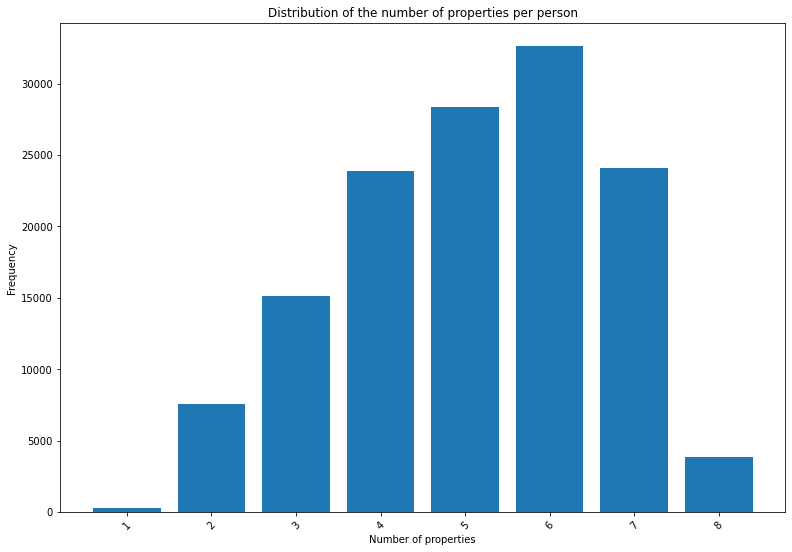

In [21]:
## Distribution of the number of properties per person

objects = [l for l in frequencies_properties_per_person.index]
eff = [l for l in frequencies_properties_per_person['properties']]

p1 = plt.bar(objects, eff)
#plt.xticks(l5Years)
plt.ylabel('Frequency')
plt.xlabel('Number of properties')
plt.title('Distribution of the number of properties per person')
plt.gcf().set_size_inches(13, 9)

positions = (0,1,2,3, 4, 5, 6,7)
labels=(1,2,3, 4, 5, 6, 7,8)

plt.xticks(positions,labels)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/properties/frequencies_properties_per_person.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()



In [9]:
# Count the pourcentage of the people have between four and six properties with the total population
print((frequencies_properties_per_person["person"][4]+frequencies_properties_per_person["person"][5]+frequencies_properties_per_person["person"][6])/(len(persons))*100,"%")

62.625258616246626 %


#### Comments:

The distribution shows a Gaussien curve. The most of people in the population have between four and six properties (it represents 62%). In opposition, few people have less than two properties and more than seven properties.

---------------------------------------

## Combination of the properties

In [10]:
# It combines the properties between them and counts and sorts them 
# A concatenation of properties label is realise with a pipe. 
sr_properties_groups = df_properties_persons['properties'].groupby(df_properties_persons['properties'].apply(lambda x : ' | '.join(x) )).count().sort_values(ascending=False)
sr_properties_groups.iloc[:30]

properties
placeOfBirth | gender | nationality | educatedAt | occupation | positionHeld               17813
placeOfBirth | gender | nationality | occupation | positionHeld                            12289
placeOfBirth | gender | nationality                                                         8055
placeOfBirth | gender | nationality | educatedAt                                            7511
gender                                                                                      7183
placeOfBirth | gender | nationality | occupation                                            7124
placeOfBirth | gender | nationality | educatedAt | occupation                               6940
gender | nationality                                                                        4879
placeOfBirth | gender | nationality | educatedAt | occupation | employer                    4434
gender | nationality | occupation | positionHeld                                            3932
placeOfBirth | gend

# Distribution of properties availables

In [11]:
# For each person, we will check if a property is entered or not. 
# It is a important step to have a preview of the availables properties and then choose 
#which ones, we will analyse. 

In [12]:
freq_persons = 0
nationality = 0
gender = 0
placeOfBirth = 0
educatedAt = 0
#doctoralAdvisor = 0
#doctoralStudent = 0
occupation = 0
positionHeld = 0
employer = 0
for i,r in list(persons.iterrows()):
    freq_persons += 1
    if r['len_nationality'] > 0:        
        nationality += 1
    if r['len_placeOfBirth'] > 0:
        placeOfBirth += 1
    if r['len_gender'] > 0:        
        gender += 1
    if r['len_educatedAt'] > 0:
        educatedAt += 1
    #if r['len_doctoralAdvisor'] > 0:
    #    doctoralAdvisor += 1
    #if r['len_doctoralStudent'] > 0:
    #    doctoralStudent += 1
    if r['len_occupation'] > 0:
        occupation += 1
    if r['len_positionHeld'] > 0:
        positionHeld += 1
    if r['len_employer'] > 0:
        employer += 1

In [13]:
frequencies_properties = pd.Series({"frequency_persons": freq_persons, "nationality": nationality, "placeOfBirth":placeOfBirth, "gender": gender, "educatedAt":educatedAt,\
                             #     "doctoralAdvisor":doctoralAdvisor, "doctoralStudent":doctoralStudent,\
                                    "occupation":occupation, "positionHeld":positionHeld, "employer":employer })
frequencies_properties

frequency_persons    135819
nationality          108342
placeOfBirth          89656
gender               134513
educatedAt            68361
occupation            78783
positionHeld          53671
employer              24335
dtype: int64

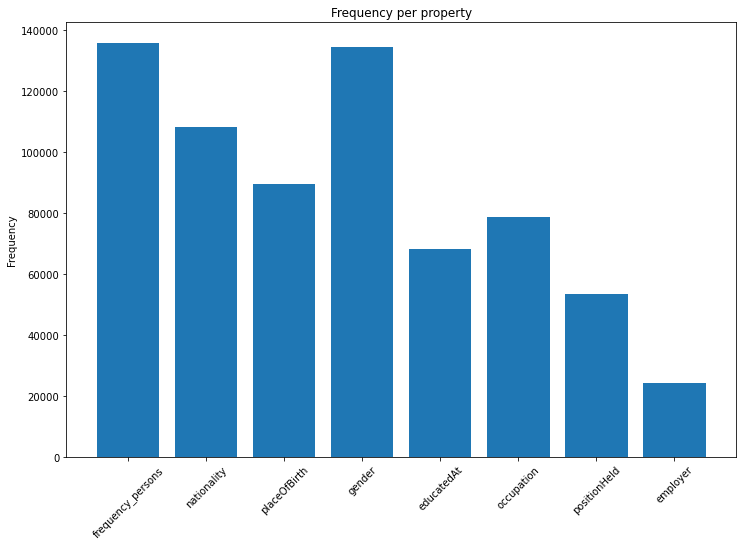

In [14]:
# Distribution of the number of the obtainable properties

objects = [l for l in frequencies_properties.index]
eff = [l for l in frequencies_properties]

p1 = plt.bar(objects, eff)

plt.ylabel('Frequency')
plt.title('Frequency per property')
plt.gcf().set_size_inches(12, 8)

plt.savefig('exported_pictures/properties/Frequency_per_available_property.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

#### **Comments**: 

The "gender" is the property the most represented, almost all people have this property entered. For gender, it is probably because, it is one of the most simple to obtain. "Nationality", "place of birth", "occupation" and "educated At" are alse well represented.

---------------------------------

# Network of the properties

Below, we will realise a network of the properties of Wikidata. The goal of this analysis is to understand which properties is more intered with which one.

Lot of commands below are realised to create the network. Then, a visualization of the graph permits to let the network more readable.

In [15]:
# It creates the edges of the network between the properties
properties_edges = []
for pp in properties_persons:
    local_properties = pp[1]
    len_prop = len(local_properties)
    # print(len_prop)
    if len_prop > 1:
        local_edges = []
        i = 0        
        while i < (len_prop-1):
            i_len = i + 1
            while i_len < (len_prop):
                local_edges.append((local_properties[i], local_properties[i_len]))
                i_len += 1        
            i += 1
        # print(local_edges)        
        properties_edges += local_edges

print(len(properties_edges))
properties_edges  [:5]

1026057


[('placeOfBirth', 'gender'),
 ('placeOfBirth', 'nationality'),
 ('placeOfBirth', 'educatedAt'),
 ('placeOfBirth', 'employer'),
 ('gender', 'nationality')]

In [16]:
# Create a network with using the edges obtained in the previous command
# cf. https://networkx.org/documentation/stable/reference/classes/multigraph.html
graph_properties = nx.MultiGraph()
graph_properties.add_edges_from(properties_edges)
print(nx.info(graph_properties))

Name: 
Type: MultiGraph
Number of nodes: 7
Number of edges: 1026057
Average degree: 293159.1429


In [17]:
# Create a dictionary with the frequency of each property
frequency = dict([(i, {'frequency': v}) for i,v in frequencies_properties.items()])
print(frequency)

{'frequency_persons': {'frequency': 135819}, 'nationality': {'frequency': 108342}, 'placeOfBirth': {'frequency': 89656}, 'gender': {'frequency': 134513}, 'educatedAt': {'frequency': 68361}, 'occupation': {'frequency': 78783}, 'positionHeld': {'frequency': 53671}, 'employer': {'frequency': 24335}}


In [18]:
# Give the number of degree for each property
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(graph_properties)])
print(degree)

{'placeOfBirth': {'degree': 335740}, 'gender': {'degree': 421289}, 'nationality': {'degree': 388656}, 'educatedAt': {'degree': 267322}, 'employer': {'degree': 102077}, 'occupation': {'degree': 311354}, 'positionHeld': {'degree': 225676}}


In [19]:
# Give the frequency and degree for each node 
nx.set_node_attributes(graph_properties, frequency)
nx.set_node_attributes(graph_properties, degree)

In [20]:
list(Counter([(u,v) for u,v in graph_properties.edges()]).items())

[(('placeOfBirth', 'gender'), 89470),
 (('placeOfBirth', 'nationality'), 79038),
 (('placeOfBirth', 'educatedAt'), 50115),
 (('placeOfBirth', 'employer'), 17049),
 (('placeOfBirth', 'occupation'), 59687),
 (('placeOfBirth', 'positionHeld'), 40381),
 (('gender', 'nationality'), 107723),
 (('gender', 'educatedAt'), 67696),
 (('gender', 'employer'), 24193),
 (('gender', 'occupation'), 78657),
 (('gender', 'positionHeld'), 53550),
 (('nationality', 'educatedAt'), 59315),
 (('nationality', 'employer'), 21525),
 (('nationality', 'positionHeld'), 50221),
 (('nationality', 'occupation'), 70834),
 (('educatedAt', 'employer'), 17400),
 (('educatedAt', 'occupation'), 42431),
 (('educatedAt', 'positionHeld'), 30365),
 (('employer', 'occupation'), 15248),
 (('employer', 'positionHeld'), 6662),
 (('occupation', 'positionHeld'), 44497)]

In [21]:
# Use the list of the previous command and create a dictionary of the weights
lll = [(l[0][0], l[0][1], {'weight' : l[1]}) for l in list(Counter([(u,v) for u,v in graph_properties.edges()]).items())]
lll

[('placeOfBirth', 'gender', {'weight': 89470}),
 ('placeOfBirth', 'nationality', {'weight': 79038}),
 ('placeOfBirth', 'educatedAt', {'weight': 50115}),
 ('placeOfBirth', 'employer', {'weight': 17049}),
 ('placeOfBirth', 'occupation', {'weight': 59687}),
 ('placeOfBirth', 'positionHeld', {'weight': 40381}),
 ('gender', 'nationality', {'weight': 107723}),
 ('gender', 'educatedAt', {'weight': 67696}),
 ('gender', 'employer', {'weight': 24193}),
 ('gender', 'occupation', {'weight': 78657}),
 ('gender', 'positionHeld', {'weight': 53550}),
 ('nationality', 'educatedAt', {'weight': 59315}),
 ('nationality', 'employer', {'weight': 21525}),
 ('nationality', 'positionHeld', {'weight': 50221}),
 ('nationality', 'occupation', {'weight': 70834}),
 ('educatedAt', 'employer', {'weight': 17400}),
 ('educatedAt', 'occupation', {'weight': 42431}),
 ('educatedAt', 'positionHeld', {'weight': 30365}),
 ('employer', 'occupation', {'weight': 15248}),
 ('employer', 'positionHeld', {'weight': 6662}),
 ('occup

In [22]:
# create a graph with the weights
weigth_graph_properties = nx.Graph()
weigth_graph_properties.add_edges_from(lll)

In [23]:
print(nx.info(weigth_graph_properties))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 21
Average degree:   6.0000


In [24]:
### add the frequencies of properties into the graph, with the 'weight' parameter
### convert a simple graph from the multigraph

# https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges
wgp = nx.Graph()
for u,v,data in graph_properties.edges.data():
    w = data['weight'] if 'weight' in data else 1
    if wgp.has_edge(u,v):
        wgp[u][v]['weight'] += w
    else:
        wgp.add_edge(u, v, weight=w)

In [25]:
### Check the created graph

# cf. nx.number_of_selfloops: https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.number_of_selfloops.html#networkx.classes.function.number_of_selfloops
# cf.  nx.is_weighted: https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.is_weighted.html

print(nx.number_of_selfloops(weigth_graph_properties))
print(nx.is_weighted(weigth_graph_properties))

0
True


In [26]:
[(u,v,data) for u,v,data in wgp.edges.data()][:3]

[('placeOfBirth', 'gender', {'weight': 89470}),
 ('placeOfBirth', 'nationality', {'weight': 79038}),
 ('placeOfBirth', 'educatedAt', {'weight': 50115})]

In [27]:
[(u,v,data) for u,v,data in weigth_graph_properties.edges.data()][4:7]

[('placeOfBirth', 'occupation', {'weight': 59687}),
 ('placeOfBirth', 'positionHeld', {'weight': 40381}),
 ('gender', 'nationality', {'weight': 107723})]

In [28]:
dict(graph_properties.nodes.data())

{'placeOfBirth': {'frequency': 89656, 'degree': 335740},
 'gender': {'frequency': 134513, 'degree': 421289},
 'nationality': {'frequency': 108342, 'degree': 388656},
 'educatedAt': {'frequency': 68361, 'degree': 267322},
 'employer': {'frequency': 24335, 'degree': 102077},
 'occupation': {'frequency': 78783, 'degree': 311354},
 'positionHeld': {'frequency': 53671, 'degree': 225676}}

In [29]:
freq_dict=dict([(n, {'frequency': data['frequency']}) for n, data in graph_properties.nodes.data()])

In [30]:
nx.set_node_attributes(weigth_graph_properties, dict([(n, {'frequency': data['frequency']}) for n, data in graph_properties.nodes.data()]))
nx.set_node_attributes(weigth_graph_properties, dict([(n, {'degree': data['degree']}) for n, data in graph_properties.nodes.data()]))

In [31]:
weigth_graph_properties.nodes.data()

NodeDataView({'placeOfBirth': {'frequency': 89656, 'degree': 335740}, 'gender': {'frequency': 134513, 'degree': 421289}, 'nationality': {'frequency': 108342, 'degree': 388656}, 'educatedAt': {'frequency': 68361, 'degree': 267322}, 'employer': {'frequency': 24335, 'degree': 102077}, 'occupation': {'frequency': 78783, 'degree': 311354}, 'positionHeld': {'frequency': 53671, 'degree': 225676}})

## Graph of the relations between properties


After having created a graph, a visualization is obtained. This visualization allows to understand which property is entered with which one other.

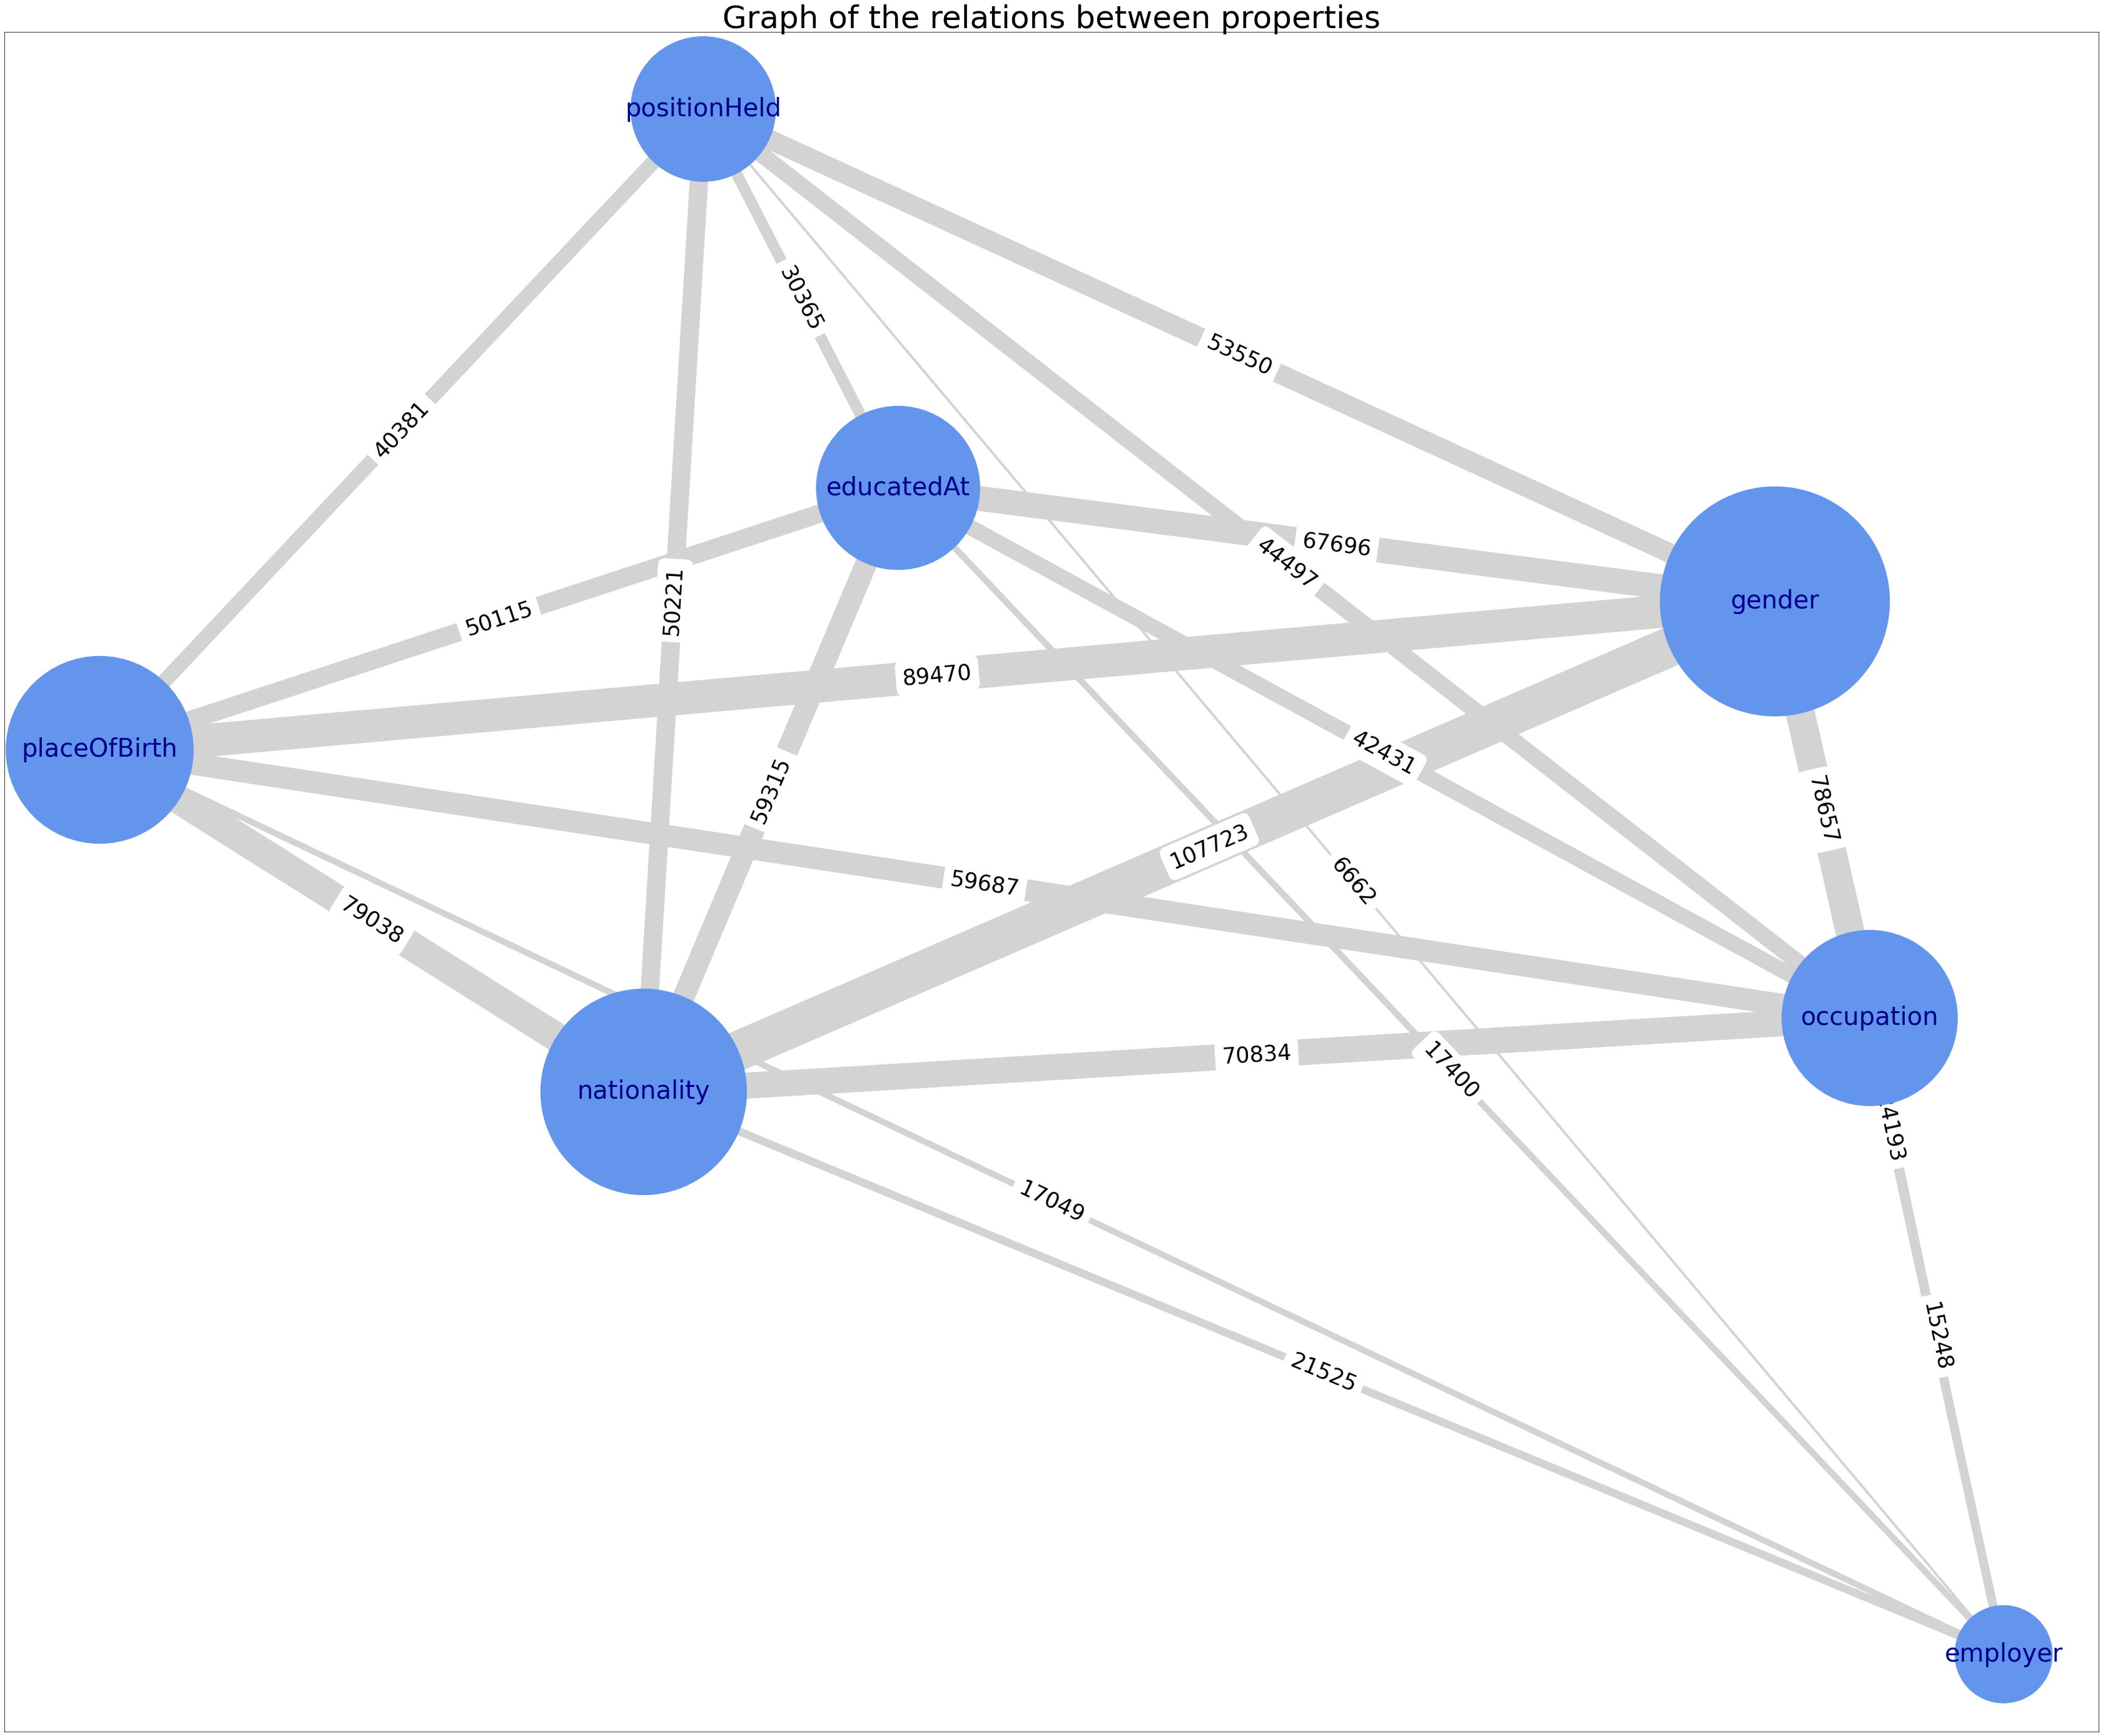

In [33]:
fig = plt.figure(figsize=(60,50))
pos = nx.spring_layout(weigth_graph_properties, k = 1)
# pos = nx.kamada_kawai_layout(weig_graph_properties)
nx.draw_networkx(weigth_graph_properties, pos, node_color = 'CornflowerBlue', font_color = 'DarkBlue',
                 font_size= 40,
                 node_size = [data['frequency'] for n,data in weigth_graph_properties.nodes.data()],
                 edge_color='LightGray',
                 width = [ d['weight'] / 1700 for u,v,d in weigth_graph_properties.edges(data=True)])
nx.draw_networkx_edge_labels(weigth_graph_properties, pos,
                 edge_labels = dict([((u,v,),str(int(d['weight'])) if d['weight'] > 1 else '') for u,v,d in weigth_graph_properties.edges(data=True)]),
                 font_size = 35
                 )
plt.title('Graph of the relations between properties', fontsize=50)
plt.savefig("exported_pictures/properties/weigth_graph_properties.png", format="png")
plt.show()

#### Comments :

* The "gender" property is on the center of the graph because all of other nodes are lot of linked to it.
* The "employer" property is outside of the network. It is less entered with a further property than the other properties.
* The "gender" and "nationality" properties are the most entered together. 

# Inspect for some variables the frequencies of the other characteristics

In [68]:
#  variables retained
observed_variables = {"educatedAt":"len_educatedAt","placeOfBirth": "len_placeOfBirth", "gender":"len_gender","nationality":"len_nationality", "employer":"len_employer", "occupation":"len_occupation", "positionHeld":"len_positionHeld", }
for i,v in observed_variables.items():
    print(i,v)

educatedAt len_educatedAt
placeOfBirth len_placeOfBirth
gender len_gender
nationality len_nationality
employer len_employer
occupation len_occupation
positionHeld len_positionHeld


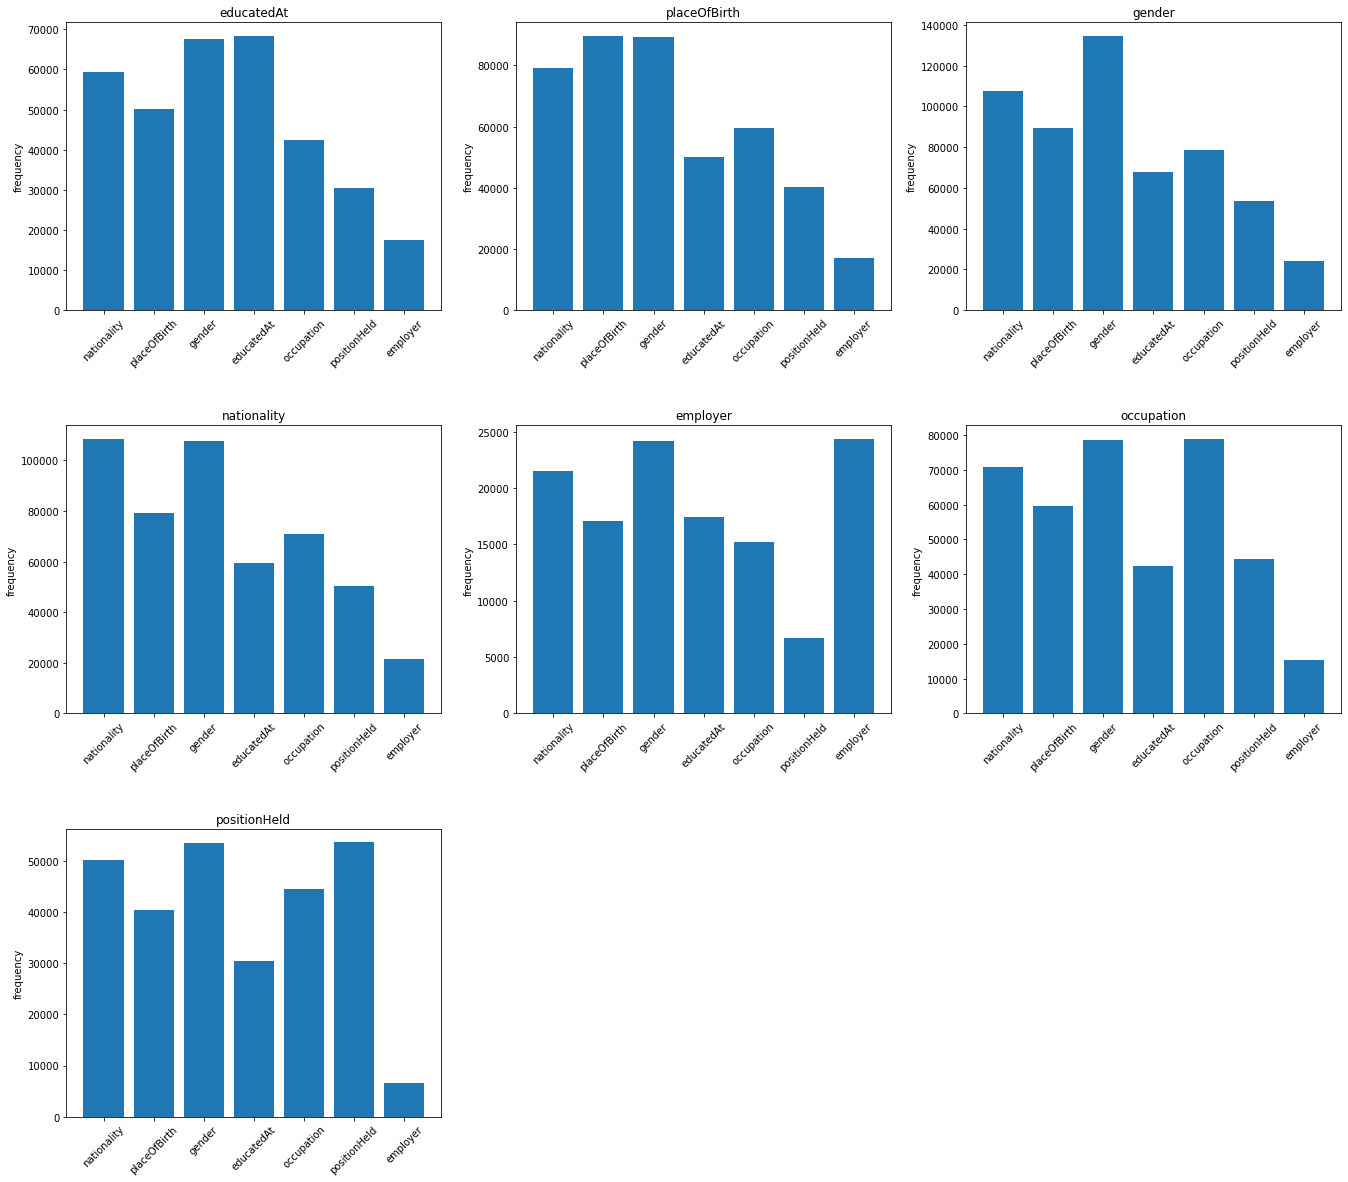

In [69]:
### To create subplot: cf. https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplot.html
### To set spacing between plots: cf. https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/

# (We have used the subplots_adjust() method (second example)) 
plot_id = 1
plot_left = 1
for ix,v in observed_variables.items():
    
    #print(ix,v)
    # This filter check if a property is entered and count then the other properties entered
    # It is necessary to initialize each variable by a zero. 
    freq_persons = 0
    nationality = 0
    placeOfBirth = 0
    gender = 0
    educatedAt = 0
    occupation = 0
    positionHeld = 0
    employer = 0
    for i,r in list(persons.iterrows()):
        if r[v] > 0:
            freq_persons += 1
            if r['len_nationality'] > 0:        
                nationality += 1
            if r['len_placeOfBirth'] > 0:
                placeOfBirth += 1
            if r['len_gender'] > 0:
                gender += 1
            if r['len_educatedAt'] > 0:
                educatedAt += 1
            if r['len_occupation'] > 0:
                occupation += 1
            if r['len_positionHeld'] > 0:
                positionHeld += 1
            if r['len_employer'] > 0:
                employer += 1
    frequencies_properties = pd.Series({"nationality": nationality, \
                                        "placeOfBirth":placeOfBirth, \
                                        "gender":gender, \
                                        "educatedAt":educatedAt,\
                                        "occupation":occupation, \
                                        "positionHeld":positionHeld, \
                                        "employer":employer })

    x = [l for l in frequencies_properties.index]
    y = [l for l in frequencies_properties]
    
 
    plt.subplot(3, 3, plot_id)

    plt.title(ix)
    
    plt.bar(x, y)
    plt.gcf().set_size_inches(12, 8)
    plt.xticks(rotation=45)

    plt.ylabel('frequency')

    
    plot_id += 1
    

plt.subplots_adjust(#left=0.1,
                   bottom=0.1, 
                   right=1.6, 
                   top=2, 
                   # wspace=0.4, 
                   hspace=0.4
                   )
plt.savefig('exported_pictures/frequencies_property_other_properties.png', dpi=100, bbox_inches = "tight") #pdf, svg
#plt.show()

#### Comments: 

* First, these visualizations confirm the "gender" property is entered with every other property. It will be possible to study the other properties by wondering the differences women/men. The same method will be used with the "nationality" property. 
* Conversely, we see that when the "employer" variable is entered, the "positionHeld" is not, like the opposite, when the "positionHeld" is entered, the "employer" is not.

* From a larger point of view, a great disproportion between the properties is observed. Even if the number of values by person is large.

# View more precisely: Filtering

Now, we check if some groups of property are available. The goal is to inspect if some properties together are usable for analysis.

In [70]:
freq_persons = 0
nationality = 0
placeOfBirth = 0
gender = 0
educatedAt = 0
occupation = 0
positionHeld = 0
employer = 0
doctoralAdvisor = 0
doctoralStudent = 0
for i,r in list(persons.iterrows()):
     if r['len_occupation'] > 0 and r['len_educatedAt'] > 0 and r['len_nationality'] > 0 and r['len_gender']:
  #  if r['len_occupation'] > 0 and r['len_positionHeld'] > 0 and \
  #  r['len_educatedAt'] > 0 and r['len_gender'] and r['len_nationality'] \
  #  and r['len_employer'] :
  #   if r['len_doctoralAdvisor'] > 0 and r['len_doctoralStudent'] > 0 and r['len_educatedAt'] > 0:
  #   if r['len_employer'] > 0 and r['len_positionHeld'] > 0 :
        freq_persons += 1
        if r['len_nationality'] > 0:        
            nationality += 1
        if r['len_placeOfBirth'] > 0:
            placeOfBirth += 1
        if r['len_gender'] > 0:
            gender += 1
        if r['len_educatedAt'] > 0:
            educatedAt += 1
        if r['len_occupation'] > 0:
            occupation += 1
        if r['len_positionHeld'] > 0:
            positionHeld += 1
        if r['len_employer'] > 0:
            employer += 1
        if r['len_doctoralAdvisor'] > 0:
            doctoralAdvisor += 1
        if r['len_doctoralStudent'] > 0:
            doctoralStudent += 1            
            
frequencies_properties_filter = pd.Series({ #"frequence_persons": freq_persons, \
                                            "nationality":nationality, \
                                            "placeOfBirth":placeOfBirth, \
                                            "gender":gender, \
                                            "educatedAt":educatedAt,\
                                            "occupation":occupation, \
                                            "positionHeld":positionHeld, \
                                            "employer":employer, \
                                            "doctoralAdvisor":doctoralAdvisor, \
                                            "doctoralStudent":doctoralStudent
                                            })
frequencies_properties_filter

nationality        40108
placeOfBirth       33080
gender             40108
educatedAt         40108
occupation         40108
positionHeld       25632
employer           10051
doctoralAdvisor     1072
doctoralStudent      879
dtype: int64

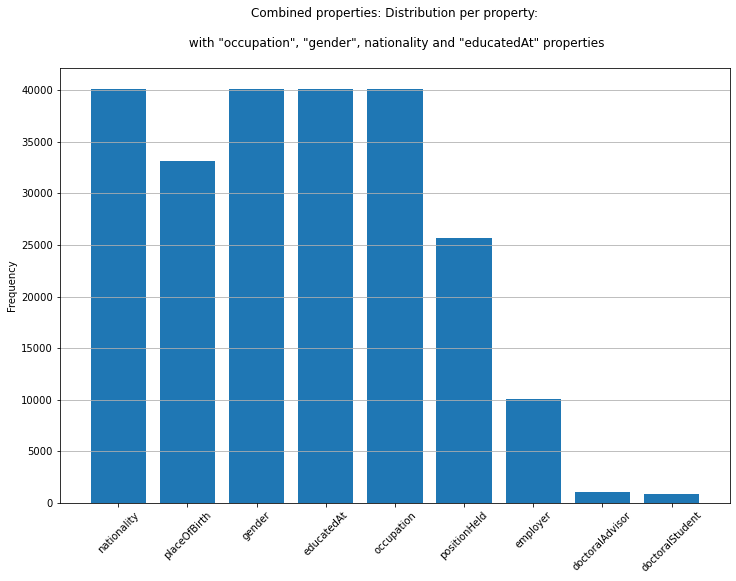

In [71]:
# Distribution per property

objects = [l for l in frequencies_properties_filter.index]
eff = [l for l in frequencies_properties_filter]


p1 = plt.bar( objects, eff)


plt.ylabel('Frequency')
plt.title('Combined properties: Distribution per property:\n\n with "occupation", "gender", nationality and "educatedAt" properties\n')
plt.gcf().set_size_inches(12, 8)

plt.grid(axis='y', linestyle='-')
#plt.savefig('exported_pictures/properties/properties_combination_occ_gend_nat_educAt.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

#### Comments: 
* The  properties "occupation", "nationality","gender","educatedAt", "positionHeld" and "employer" :
 - These combined properties exist on 3000 persons. It is little compared to the total population.
* The  properties "position held" and "employer" properties:
 - These both joined properties exist on 6000 persons. 
* The  properties "doctoralStudent", "doctoralAdvisor" and "educatedAt" properties:
 - These combined properties exist on 1400 persons.
 - There is also the majority of the "employer" property entered with them.
 - It will be interesting to study this sub-population for observing their career and the connections between them.


-------------------------------------------

## Filter on the properties per person

In this section, we realize the same inspection but we focus on the persons. The date of birth of the population will be used to achieve this filter. It is the number of people with the properties per period that we seek.

In [325]:
properties_persons_filtered = []
for i,r in list(persons.iterrows()):
    
    ### Filter:
    
 #  if r['len_occupation'] > 0 and r['len_educatedAt'] > 0 and r['len_nationality'] > 0 and r['len_gender'] >0:
 #  if r['len_employer'] > 0 and r['len_positionHeld'] > 0 and r['len_educatedAt'] > 0:
 #  if r['len_employer'] > 0 and r['len_occupation'] > 0 and r['len_educatedAt'] > 0:
 #  if r['len_employer'] > 0 and r['len_positionHeld'] > 0 :
 #  if r['len_doctoralStudent'] > 0 and r['len_doctoralAdvisor'] > 0 and r['len_educatedAt'] > 0:
 #  if r['len_occupation'] > 0:
 #   if r['len_nationality'] > 0:
 #   if r['len_employer'] > 0:
     if r['len_positionHeld'] > 0 :
        properties = []    
        if r['len_placeOfBirth'] > 0:
            properties.append('placeOfBirth')
        if r['len_gender'] > 0:
            properties.append('gender')
        if r['len_nationality'] > 0:        
            properties.append('nationality')
        if r['len_educatedAt'] > 0:
            properties.append('educatedAt')
        if r['len_occupation'] > 0:
            properties.append('occupation')
        if r['len_positionHeld'] > 0:
            properties.append('positionHeld')
        if r['len_employer'] > 0:
            properties.append('employer')
     #   if r['len_doctoralAdvisor'] > 0:
     #       properties.append('doctoralAdvisor')
     #   if r['len_doctoralStudent'] > 0:
     #       properties.append('doctoralStudent')

        properties_persons_filtered.append([i, properties, len(properties)])        

#print(len(properties_persons_filtered))    
#properties_persons_filtered[0:11]

In [326]:
properties_persons_filtered= pd.DataFrame(properties_persons_filtered, columns=['person', 'properties', 'frequency'])
properties_persons_filtered.head()

,person,properties,frequency
0,urn:uuid:0000ce52-b76a-466b-af20-dfcb82dda79e,"[gender, nationality, educatedAt, positionHeld]",4
1,urn:uuid:000112b4-4917-4e23-a009-0c9bf8b6457b,"[gender, nationality, educatedAt, occupation, ...",5
2,urn:uuid:00033b44-dea6-4a45-bd42-c4995e5e3919,"[placeOfBirth, gender, nationality, educatedAt...",6
3,urn:uuid:00034d59-7ac8-4638-a0e9-af297e6ec3c0,"[placeOfBirth, gender, nationality, educatedAt...",5
4,urn:uuid:0003a60a-43e0-4f10-b6a2-ccec94311b09,"[placeOfBirth, gender, nationality, occupation...",5


In [327]:
persons.head()

,birthDate,nationality,len_nationality,gender,len_gender,placeOfBirth,len_placeOfBirth,educatedAt,len_educatedAt,doctoralAdvisor,len_doctoralAdvisor,doctoralStudent,len_doctoralStudent,occupation,len_occupation,positionHeld,len_positionHeld,employer,len_employer
person,,,,,,,,,,,,,,,,,,,
urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,1924,Japan,1,male,1,Tokyo,1,Hitotsubashi University|Yokohama City University,2,NaN,0,NaN,0,NaN,0,NaN,0,Kanagawa University|Yokohama City University,2
urn:uuid:0000725e-52b1-454f-9a00-e5d6369cd916,1977,NaN,0,female,1,Prostějov,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
urn:uuid:0000beac-029c-46f4-b8a8-a41dc5247a7f,1978,NaN,0,male,1,NaN,0,University of Amsterdam,1,H. Peter Boswijk|Frank de Jong,2,NaN,0,consultant,1,NaN,0,NaN,0
urn:uuid:0000ce52-b76a-466b-af20-dfcb82dda79e,1932,British India|India|Dominion of India,3,male,1,NaN,0,Panjab University,1,NaN,0,NaN,0,NaN,0,judge of the Supreme Court of India,1,NaN,0
urn:uuid:000112b4-4917-4e23-a009-0c9bf8b6457b,1955,Portugal,1,male,1,NaN,0,University of Lisbon|University of Lisbon (191...,2,NaN,0,NaN,0,politician,1,Member of the Assembly of the Republic|Ministe...,2,NaN,0


In [328]:
merged = pd.merge(properties_persons_filtered, persons, on='person', sort=False)
print(len(merged))
merged.sort_values(by=['birthDate']).head(10)

53671


,person,properties,frequency,birthDate,nationality,len_nationality,gender,len_gender,placeOfBirth,len_placeOfBirth,...,doctoralAdvisor,len_doctoralAdvisor,doctoralStudent,len_doctoralStudent,occupation,len_occupation,positionHeld,len_positionHeld,employer,len_employer
5605,urn:uuid:1a7d3119-4129-4ceb-b5c2-33138a505834,"[placeOfBirth, gender, nationality, occupation...",5,1770,United States of America,1,male,1,Frederick,1,...,NaN,0,NaN,0,politician,1,United States representative|Member of the Uni...,2,NaN,0
51072,urn:uuid:f39a922e-1482-41b3-9998-a706fd726d8b,"[gender, nationality, occupation, positionHeld]",4,1770,United States of America,1,male,1,NaN,0,...,NaN,0,NaN,0,politician,1,United States representative|member of the Pen...,2,NaN,0
26286,urn:uuid:7d7b882e-76ef-433e-9cec-4be74f68f653,"[placeOfBirth, gender, nationality, educatedAt...",6,1770,United States of America,1,male,1,Philadelphia,1,...,NaN,0,NaN,0,politician|songwriter,2,United States representative|Member of the New...,2,NaN,0
9645,urn:uuid:2db0a4bb-1e1d-423e-8531-8fadecd94b12,"[placeOfBirth, gender, nationality, occupation...",5,1770,France,1,male,1,Ajaccio,1,...,NaN,0,NaN,0,politician,1,deputy,1,NaN,0
45486,urn:uuid:d92406ff-8df2-4fab-9412-67fad1db9994,"[gender, nationality, occupation, positionHeld]",4,1770,Canada,1,male,1,NaN,0,...,NaN,0,NaN,0,politician,1,member of the Nova Scotia House of Assembly,1,NaN,0
49283,urn:uuid:eb37a1ec-074a-4933-9db1-06a01d016e51,"[placeOfBirth, gender, nationality, educatedAt...",6,1770,United States of America,1,male,1,Morristown,1,...,NaN,0,NaN,0,politician,1,United States representative|member of the New...,2,NaN,0
41973,urn:uuid:c807ee1d-3f66-4b66-8485-54bf660687b3,"[gender, nationality, occupation, positionHeld]",4,1770,United Kingdom of Great Britain and Ireland|Gr...,2,male,1,NaN,0,...,NaN,0,NaN,0,politician,1,Member of the 2nd Parliament of the United Kin...,1,NaN,0
740,urn:uuid:036e29a6-3328-443e-b9da-5159bf7635e4,"[placeOfBirth, gender, nationality, occupation...",5,1770,United States of America,1,male,1,Amherst,1,...,NaN,0,NaN,0,politician,1,United States representative|Member of the New...,3,NaN,0
31410,urn:uuid:95dc2888-e633-4ffd-a965-a4ad7955eb92,"[placeOfBirth, gender, nationality, educatedAt...",6,1770,United States of America,1,male,1,South Carolina,1,...,NaN,0,NaN,0,politician,1,United States representative|United States sen...,5,NaN,0
25176,urn:uuid:785d60ed-ca5e-4e66-a8b3-01fd349b382d,"[placeOfBirth, gender, nationality, positionHeld]",4,1770,United States of America,1,male,1,Prince George's County,1,...,NaN,0,NaN,0,NaN,0,Supreme Court of Ohio,1,NaN,0


In [329]:
min(merged['birthDate']),max(merged['birthDate'])

(1770, 2008)

In [330]:
y20_list = pd.RangeIndex(start=1801, stop=1951, step=20).to_list()
y20_list

[1801, 1821, 1841, 1861, 1881, 1901, 1921, 1941]

In [331]:
# Useful to know the type of "birthDate"
merged.dtypes

person                 object
properties             object
frequency               int64
birthDate               int64
nationality            object
len_nationality         int64
gender                 object
len_gender              int64
placeOfBirth           object
len_placeOfBirth        int64
educatedAt             object
len_educatedAt          int64
doctoralAdvisor        object
len_doctoralAdvisor     int64
doctoralStudent        object
len_doctoralStudent     int64
occupation             object
len_occupation          int64
positionHeld           object
len_positionHeld        int64
employer               object
len_employer            int64
dtype: object

In [332]:
# Code the type of "birthDate", from object to integer
# The change is necessary to realise the aggregating below 
# because the datas with the list of generation above must be of the same type 
merged['birthDate']=merged['birthDate'].astype(object).astype(int)

In [333]:
# Code the years by aggregating them per twenty-year period

merged['generation'] = pd.cut(merged['birthDate'],y20_list, right=False)
merged['generation'] = merged['generation'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
merged['generation'].head()

0    1921-1941
1          NaN
2    1841-1861
3          NaN
4    1821-1841
Name: generation, dtype: category
Categories (7, object): ['1801-1821' < '1821-1841' < '1841-1861' < '1861-1881' < '1881-1901' < '1901-1921' < '1921-1941']

In [334]:
# Create a list of ten-year period
y10_list = pd.RangeIndex(start=1801, stop=1950, step=10).to_list()
y10_list

[1801,
 1811,
 1821,
 1831,
 1841,
 1851,
 1861,
 1871,
 1881,
 1891,
 1901,
 1911,
 1921,
 1931,
 1941]

In [335]:
# Code the years by aggregating them per ten-year period

merged['decades'] = pd.cut(merged['birthDate'], y10_list, right=False)
merged['decades'] = merged['decades'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
merged.head()

,person,properties,frequency,birthDate,nationality,len_nationality,gender,len_gender,placeOfBirth,len_placeOfBirth,...,doctoralStudent,len_doctoralStudent,occupation,len_occupation,positionHeld,len_positionHeld,employer,len_employer,generation,decades
0,urn:uuid:0000ce52-b76a-466b-af20-dfcb82dda79e,"[gender, nationality, educatedAt, positionHeld]",4,1932,British India|India|Dominion of India,3,male,1,NaN,0,...,NaN,0,NaN,0,judge of the Supreme Court of India,1,NaN,0,1921-1941,1931-1941
1,urn:uuid:000112b4-4917-4e23-a009-0c9bf8b6457b,"[gender, nationality, educatedAt, occupation, ...",5,1955,Portugal,1,male,1,NaN,0,...,NaN,0,politician,1,Member of the Assembly of the Republic|Ministe...,2,NaN,0,NaN,NaN
2,urn:uuid:00033b44-dea6-4a45-bd42-c4995e5e3919,"[placeOfBirth, gender, nationality, educatedAt...",6,1848,Austria-Hungary,1,male,1,Slap,1,...,NaN,0,politician,1,Member of Abgeordnetenhaus,1,NaN,0,1841-1861,1841-1851
3,urn:uuid:00034d59-7ac8-4638-a0e9-af297e6ec3c0,"[placeOfBirth, gender, nationality, educatedAt...",5,1954,United States of America,1,female,1,Jackson Heights,1,...,NaN,0,NaN,0,Judge of the United States Court of Appeals fo...,1,NaN,0,NaN,NaN
4,urn:uuid:0003a60a-43e0-4f10-b6a2-ccec94311b09,"[placeOfBirth, gender, nationality, occupation...",5,1831,France,1,male,1,Nantillois,1,...,NaN,0,politician|diplomat,2,senator of the French Third Republic|premier p...,2,NaN,0,1821-1841,1831-1841


In [336]:
### Frequency per generation

In [337]:
# Frequency per generation
gb_generation = merged.groupby('generation').size()
gb_generation

generation
1801-1821    3853
1821-1841    4037
1841-1861    4402
1861-1881    4944
1881-1901    4774
1901-1921    5162
1921-1941    6840
dtype: int64

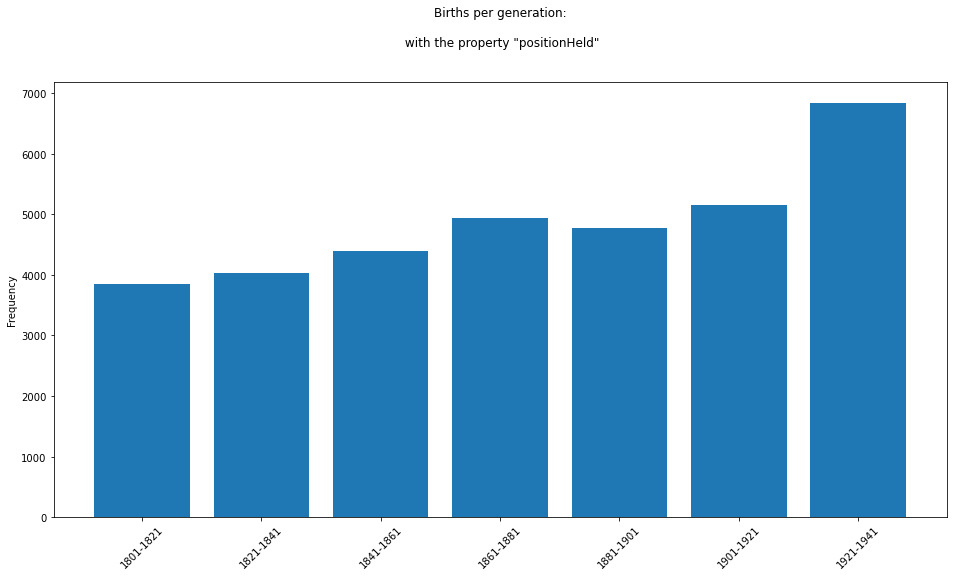

In [339]:
# Distribution per generation with limited population (by the properties choosed above)

objects = [l for l in gb_generation.index]
eff = [l for l in gb_generation]

p1 = plt.bar(objects, eff)

plt.ylabel('Frequency')
plt.title('Births per generation:\n\n with the property "positionHeld"\n\n')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/properties/birth/Frequency_birth_generation_period_positionHeld.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

In [323]:
# Frequency per decades
gb_decades = merged.groupby('decades').size()
gb_decades

decades
1801-1811    2396
1811-1821    2748
1821-1831    2797
1831-1841    2873
1841-1851    3334
1851-1861    3578
1861-1871    4116
1871-1881    4652
1881-1891    4827
1891-1901    4831
1901-1911    6032
1911-1921    5568
1921-1931    7563
1931-1941    8497
dtype: int64

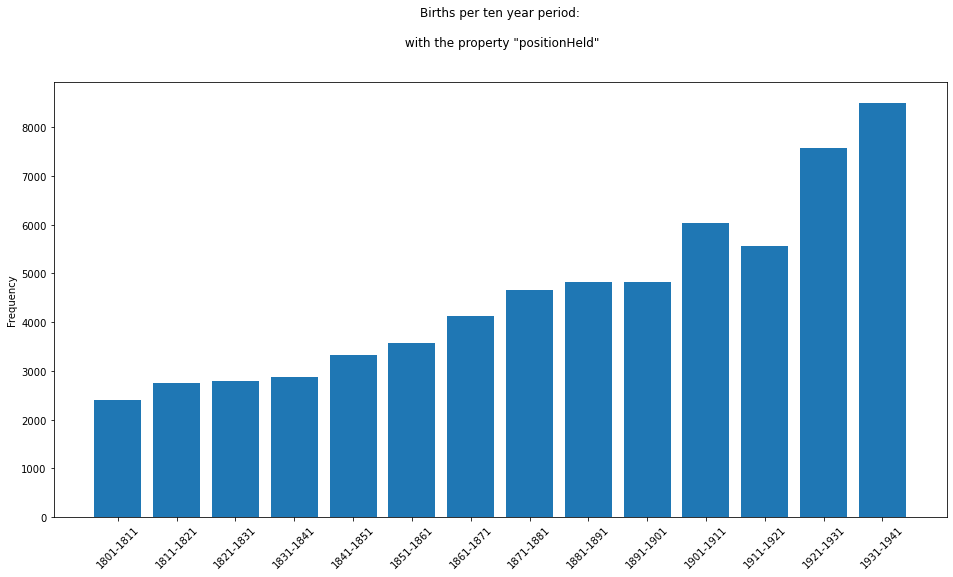

In [340]:
# Distribution per decades with limited population (by the properties choosed above)
objects = [l for l in gb_decades.index]
eff = [l for l in gb_decades]

p1 = plt.bar(objects, eff)

plt.ylabel('Frequency')
plt.title('Births per ten year period:\n\n with the property "positionHeld"\n\n')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/properties/birth/Frequency_birth_decades_period_positionHeld.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

#### Comments: 

* For each property, the curve is always more or less the same. It rises slowly in the 19th century and rises very quickly in the 20th century. This could be explained by the greater number of individuals during the 20th century.

In [341]:
y5_list = pd.RangeIndex(start=1801, stop=1951, step=5).to_list()
#y5_list

In [342]:
# Code the years by aggregating them per twenty-year period

merged['five-year'] = pd.cut(merged['birthDate'],y5_list, right=False)
merged['five-year'] = merged['five-year'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
merged['five-year'].head()

0    1931-1936
1          NaN
2    1846-1851
3          NaN
4    1831-1836
Name: five-year, dtype: category
Categories (29, object): ['1801-1806' < '1806-1811' < '1811-1816' < '1816-1821' ... '1926-1931' < '1931-1936' < '1936-1941' < '1941-1946']

In [343]:
# Frequency per decades
gb_5year = merged.groupby('five-year').size()
gb_5year

five-year
1801-1806     805
1806-1811     946
1811-1816    1011
1816-1821    1091
1821-1826    1021
1826-1831    1029
1831-1836     993
1836-1841     994
1841-1846    1079
1846-1851    1071
1851-1856    1077
1856-1861    1175
1861-1866    1141
1866-1871    1250
1871-1876    1273
1876-1881    1280
1881-1886    1163
1886-1891    1233
1891-1896    1147
1896-1901    1231
1901-1906    1395
1906-1911    1221
1911-1916    1282
1916-1921    1264
1921-1926    1519
1926-1931    1763
1931-1936    1700
1936-1941    1858
1941-1946    2253
dtype: int64

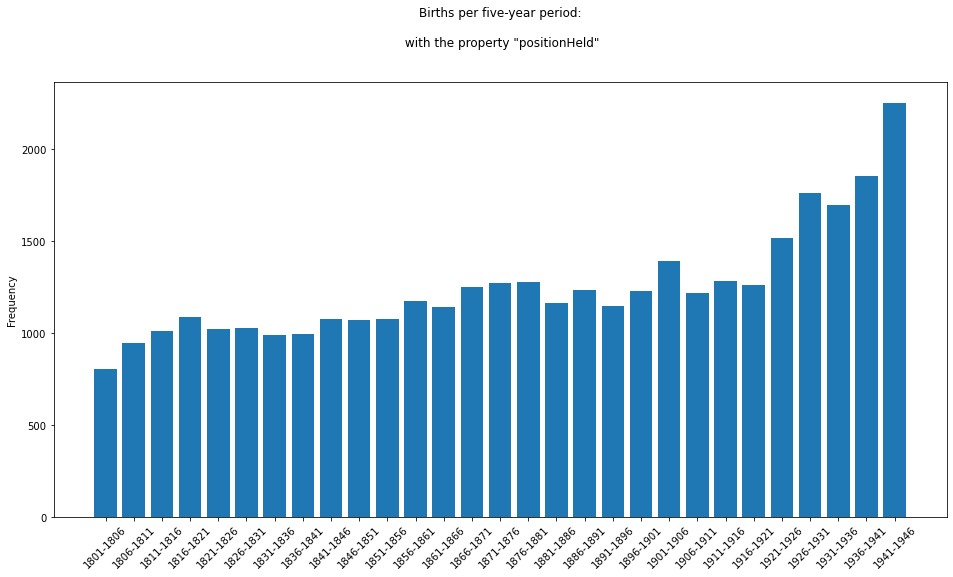

In [344]:
# Distribution per decades with limited population (by the properties choosed above)
objects = [l for l in gb_5year.index]
eff = [l for l in gb_5year]

p1 = plt.bar(objects, eff)

plt.ylabel('Frequency')
plt.title('Births per five-year period:\n\n with the property "positionHeld"\n\n')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/properties/birth/Frequency_birth_5year_period_positionHeld.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

In [345]:
yearSup1920=merged[merged['birthDate'] >= 1920]
yearSup1920=yearSup1920[yearSup1920['birthDate'] <= 1950].groupby('birthDate')['birthDate'].count()

yearSup1920.sort_values(ascending = True).head()

birthDate
1922    268
1920    292
1933    301
1921    305
1924    315
Name: birthDate, dtype: int64

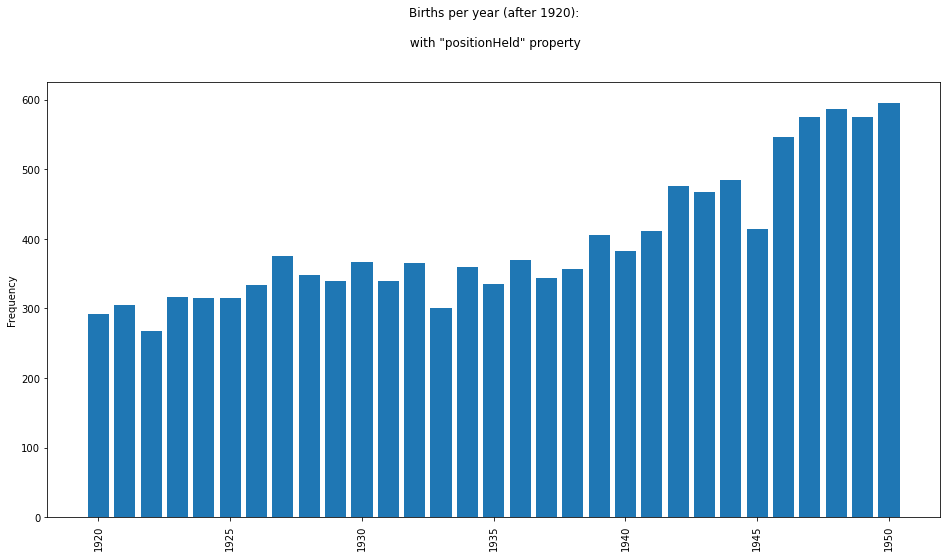

In [346]:
# Distribution per decades with limited population (by the properties choosed above)
objects = [l for l in yearSup1920.index]
eff = [l for l in yearSup1920]

p1 = plt.bar(objects, eff)

plt.ylabel('Frequency')
plt.title('Births per year (after 1920):\n\n with "positionHeld" property\n\n')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/properties/birth/Frequency_birth_years_after1920_positionHeld.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=90)
plt.show()

In [347]:
yearInf1920=merged[merged['birthDate'] < 1920].groupby('birthDate')['birthDate'].count()
yearInf1920.sort_values(ascending = True).head()

birthDate
1771    38
1774    47
1775    58
1777    60
1770    61
Name: birthDate, dtype: int64

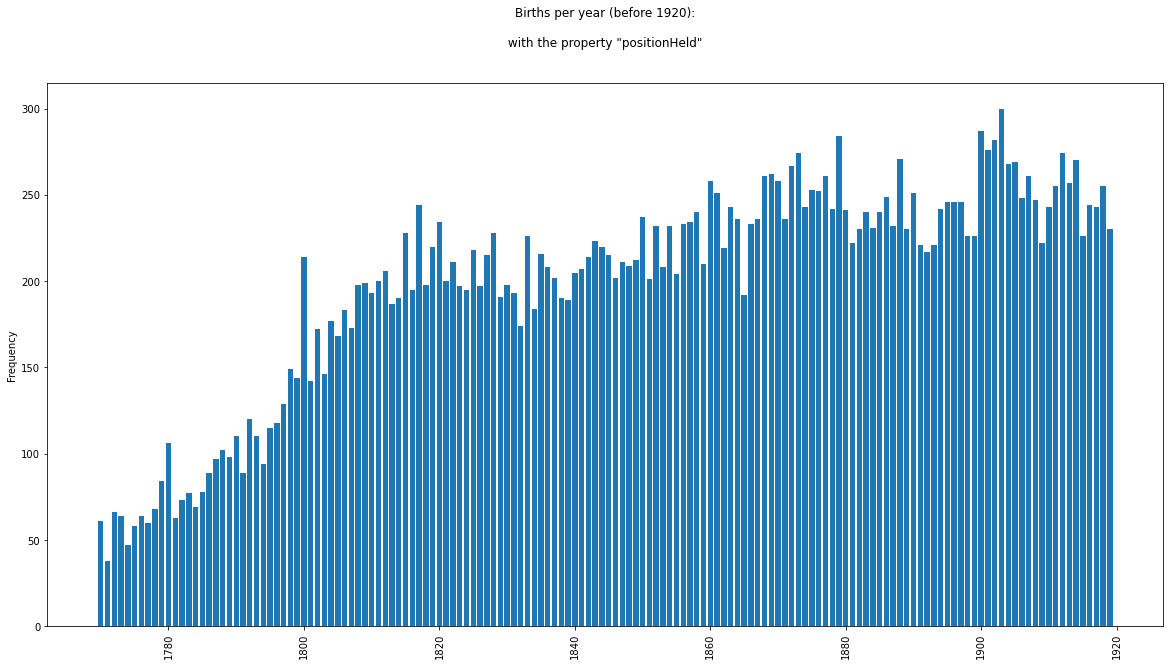

In [348]:
# Distribution per decades with limited population (by the properties choosed above)
objects = [l for l in yearInf1920.index]
eff = [l for l in yearInf1920]

p1 = plt.bar(objects, eff)

plt.ylabel('Frequency')
plt.title('Births per year (before 1920):\n\n with the property "positionHeld" \n\n')
plt.gcf().set_size_inches(20, 10)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/properties/birth/Frequency_birth_years_before1920_positionHeld.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=90)
plt.show()